In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import gridspec
import xarray as xr
import xmitgcm

import sys
import os
import time
import xrft

from dask.array import ones_like
from dask.diagnostics import ProgressBar

from matplotlib.colors import LogNorm
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import cmocean

from IPython import display
from IPython.display import clear_output
import pandas as pd

In [2]:
import matplotlib.patches as patches

In [3]:
plt.rcParams.update({'font.size': 16
    , 'legend.markerscale': 1., 'axes.titlesize': 20, 'axes.labelsize' : 12,
      'legend.fontsize' : 14,'legend.handlelength': 3})

plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12)

color2 = '#6495ed'
color1 = '#ff6347'
color5 = '#8470ff'
color3 = '#3cb371'
color4 = '#ffd700'
color6 = '#ba55d3'

colors = [color1, color2, color4,color3, ]
plt.rcParams.update({'figure.figsize' : (15,5)})

import matplotlib as mpl
mpl.rcParams['text.usetex'] = True

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
blue = cm.get_cmap('Blues', 256)
green = cm.get_cmap('Greens', 256)
red = cm.get_cmap('Reds', 256)
grey = cm.get_cmap('Greys', 256)
bone = cm.get_cmap('bone_r', 256)
binary = cm.get_cmap('binary', 256)
hot = cm.get_cmap('hot_r', 256)
gray = cm.get_cmap('gray_r', 256)

newcolors = blue(np.linspace(0, 1, 256))**2*grey(np.linspace(0, 1, 256))**0.2
newcmp = ListedColormap(newcolors[::-1], name='BlueGrey')
newcmp2 = ListedColormap(newcolors, name='BlueGrey_r')

In [4]:
dirsmall = '/central/groups/oceanphysics/anirban/smalldomain_4h/'
dirmw = '/central/groups/oceanphysics/anirban/modewater/'
ddir = '/central/groups/oceanphysics/anirban/surfaceKE_mm/'
dir_grid = ['/central/groups/oceanphysics/anirban/grid_uniform/grid_2km/',
            '/central/groups/oceanphysics/anirban/grid_uniform/grid_4km/',
            '/central/groups/oceanphysics/anirban/grid_uniform/grid_8km/',
            '/central/groups/oceanphysics/anirban/grid_uniform/grid_16km/',
            
            ]


dirroot_s = '/central/groups/oceanphysics/anirban/smalldomain_4h/'

res = ['2km','4km','8km','16km']
res2 = ['2km','4km','8km']
deltaT = [80,200,200,300]

xs1 = [720,360,180,90]
xs2 = [1120,560,280,140]
ys1 = [120,60,30,15]
ys2 = [480,240,120,60]




zlevels = np.array([1., 2., 3., 4., 5., 6., 7., 8., 9.,10.,11.,12.,13.,14.,15.,
                    16.,17.,18.,19.,20.,21.,22.,23.,24.,25.,26.,27.,28.,29.,30.,
                    31.,32.,33.,34.,35.,36.,37.,38.,39.,40.,41.,42.,43.,44.,45.,
                    46.,47.,48.,49.,50.,51.,52.,53.,54.,55.,56.,57.,58.,])
zlevels = (zlevels -1).astype(int)


grids = {}
grids2 = {}
x = {}
y = {}
X = {}
Y = {}
mask = {}
landmask = {}

for it, r in enumerate(res):
    grids[r] = xmitgcm.open_mdsdataset(dir_grid[it], delta_t=deltaT[it],
                                       ref_date="2008-01-01 00:00:00", iters = None)

    grids2[r] = grids[r].isel(XC=slice(xs1[it], xs2[it]),XG=slice(xs1[it], xs2[it]),
                           YC=slice(ys1[it], ys2[it]),YG=slice(ys1[it], ys2[it]),
                           Z = zlevels, Zl = zlevels, Zu = zlevels, Zp1 = zlevels,).drop(['Zp1'])
    x[r] = grids[r].XC.values
    y[r] = grids[r].YC.values
    X[r],Y[r] = np.meshgrid(x[r],y[r])
    mask[r] = grids[r].sel(Z=0, method='nearest').hFacC.values
    landmask[r] = np.ma.masked_where(mask[r]==1, mask[r])

/central/groups/oceanphysics/anirban/miniconda/envs/myenvironment2/lib/python3.7/site-packages/xmitgcm/mds_store.py:914: UserWarning: Couldn't find available_diagnostics.log in /central/groups/oceanphysics/anirban/grid_uniform/grid_2km/ or /central/groups/oceanphysics/anirban/grid_uniform/grid_2km/. Using default version.
  "in %s or %s. Using default version." % (data_dir, grid_dir))
/central/groups/oceanphysics/anirban/miniconda/envs/myenvironment2/lib/python3.7/site-packages/xmitgcm/mds_store.py:914: UserWarning: Couldn't find available_diagnostics.log in /central/groups/oceanphysics/anirban/grid_uniform/grid_4km/ or /central/groups/oceanphysics/anirban/grid_uniform/grid_4km/. Using default version.
  "in %s or %s. Using default version." % (data_dir, grid_dir))
/central/groups/oceanphysics/anirban/miniconda/envs/myenvironment2/lib/python3.7/site-packages/xmitgcm/mds_store.py:914: UserWarning: Couldn't find available_diagnostics.log in /central/groups/oceanphysics/anirban/grid_unifo

In [5]:
ds_ecco = xr.open_dataset('/central/groups/oceanphysics/anirban/eccov4r4_THETA_NA.nc')
mwecco = xr.open_dataset('/central/groups/oceanphysics/anirban/surfaceKE_mm/eccov4r4_modewatervolume_timeseries.nc')
times_ecco = pd.date_range('1992-1-1', '2017-12-31', freq='M')


In [6]:
mwv = {}
S67 = {}
S64 = {}
S55 = {}
S52 = {}

for r in res:
    mwv[r] = xr.open_dataset(ddir + r + '_modewatervolume_timeseries.nc')
    S67[r] = xr.open_dataset(ddir + r + '_S67.nc')
    S64[r] = xr.open_dataset(ddir + r + '_S64.nc')
    S55[r] = xr.open_dataset(ddir + r + '_S55.nc')
    S52[r] = xr.open_dataset(ddir + r + '_S52.nc')
    

In [7]:
T67_clim = {}
T64_clim = {}
T55_clim = {}
T52_clim = {}

T67= {}
T64 = {}
T55 = {}
T52 = {}

for r in res:
    T67_clim[r] = S67[r].T.where(S67[r].hFacC).sel(time=slice('2015','2049')).groupby('time.month').mean(dim='time')
    T67[r] = S67[r].T.sel(time=slice('2015','2049')).mean(dim='time')
    
    T64_clim[r] = S64[r].T.where(S64[r].hFacC).sel(time=slice('2015','2049')).groupby('time.month').mean(dim='time')
    T64[r] = S64[r].T.sel(time=slice('2015','2049')).mean(dim='time')

    T55_clim[r] = S55[r].T.where(S55[r].hFacC).sel(time=slice('2015','2049')).groupby('time.month').mean(dim='time')
    T55[r] = S55[r].T.sel(time=slice('2015','2049')).mean(dim='time')

    T52_clim[r] = S52[r].T.where(S52[r].hFacC).sel(time=slice('2015','2049')).groupby('time.month').mean(dim='time')
    T52[r] = S52[r].T.sel(time=slice('2015','2049')).mean(dim='time')


In [8]:
S67_ecco = ds_ecco.where((ds_ecco.longitude>-67.3)&(ds_ecco.longitude<-66.7), drop=True).mean(dim='i')
S64_ecco = ds_ecco.where((ds_ecco.longitude>-64.3)&(ds_ecco.longitude<-63.7), drop=True).mean(dim='i')
S55_ecco = ds_ecco.where((ds_ecco.longitude>-55.3)&(ds_ecco.longitude<-54.7), drop=True).mean(dim='i')
S52_ecco = ds_ecco.where((ds_ecco.longitude>-52.3)&(ds_ecco.longitude<-51.7), drop=True).mean(dim='i')

T67['eccov4r4'] = xr.DataArray(S67_ecco.THETA.values, dims = ['time','Z', 'YC'],
                       coords = {'time': times_ecco, 'Z': S67_ecco.Z.values, 'YC' : ds_ecco.latitude.values})
T64['eccov4r4'] = xr.DataArray(S64_ecco.THETA.values, dims = ['time','Z', 'YC'],
                       coords = {'time': times_ecco, 'Z': S64_ecco.Z.values, 'YC' : ds_ecco.latitude.values})
T55['eccov4r4'] = xr.DataArray(S55_ecco.THETA.values, dims = ['time','Z', 'YC'],
                       coords = {'time': times_ecco, 'Z': S55_ecco.Z.values, 'YC' : ds_ecco.latitude.values})
T52['eccov4r4'] = xr.DataArray(S52_ecco.THETA.values, dims = ['time','Z', 'YC'],
                       coords = {'time': times_ecco, 'Z': S52_ecco.Z.values, 'YC' : ds_ecco.latitude.values})


In [9]:
t67 = {}
t64 = {}
t55 = {}
t52 = {}

for r in ['eccov4r4']:
    
    t67[r] = T67[r].mean(dim='time')
    t64[r] = T64[r].mean(dim='time')
    t55[r] = T55[r].mean(dim='time')
    t52[r] = T52[r].mean(dim='time')
mwv['eccov4r4'] = mwecco

In [10]:
%%time

mwtpv = {}
pvsmall = {}
for r in res:
    pvsmall[r] = xr.open_mfdataset(dirsmall+r+'/'+r+'_pv_modewater_*.nc')
    print('PV, smalldomain, ' + r)
    mwtpv[r] = xr.open_mfdataset(dirmw +r+'_mw_t_v_fbz_*.nc')
    print('Modewater full, ' + r)


PV, smalldomain, 2km
Modewater full, 2km
PV, smalldomain, 4km
Modewater full, 4km
PV, smalldomain, 8km
Modewater full, 8km
PV, smalldomain, 16km
Modewater full, 16km
CPU times: user 3min 49s, sys: 19.3 s, total: 4min 8s
Wall time: 9min 36s


In [11]:
mwtpv['2km']

<xarray.Dataset>
Dimensions:  (time: 501, XC: 2960, YC: 800)
Coordinates:
  * time     (time) int64 2678400 5184000 7862400 ... 1314921600 1317513600
    iter     (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * XC       (XC) float32 -81.57 -81.54 -81.52 -81.49 ... -5.964 -5.939 -5.913
  * YC       (YC) float32 26.87 26.89 26.91 26.93 ... 43.45 43.47 43.49 43.51
    rA       (YC, XC) float32 dask.array<chunksize=(800, 2960), meta=np.ndarray>
    Depth    (YC, XC) float32 dask.array<chunksize=(800, 2960), meta=np.ndarray>
    maskInC  (YC, XC) bool dask.array<chunksize=(800, 2960), meta=np.ndarray>
Data variables:
    mwt      (time, YC, XC) float32 dask.array<chunksize=(1, 800, 2960), meta=np.ndarray>
    mwv      (time, YC, XC) float32 dask.array<chunksize=(1, 800, 2960), meta=np.ndarray>
    fbz_mw   (time, YC, XC) float64 dask.array<chunksize=(1, 800, 2960), meta=np.ndarray>

In [12]:
mwfbz = {}
for r in res:
    mwfbz[r] = mwtpv[r].drop(['mwt', 'mwv', 'iter'])
    mwfbz[r].coords['time'] = pd.date_range(start='2008-02-01', periods=len(mwfbz[r].time), freq='MS')


In [12]:
mwfbz['2km']

<xarray.Dataset>
Dimensions:  (time: 501, XC: 2960, YC: 800)
Coordinates:
  * time     (time) datetime64[ns] 2008-02-01 2008-03-01 ... 2049-10-01
  * XC       (XC) float32 -81.57 -81.54 -81.52 -81.49 ... -5.964 -5.939 -5.913
  * YC       (YC) float32 26.87 26.89 26.91 26.93 ... 43.45 43.47 43.49 43.51
    rA       (YC, XC) float32 dask.array<chunksize=(800, 2960), meta=np.ndarray>
    Depth    (YC, XC) float32 dask.array<chunksize=(800, 2960), meta=np.ndarray>
    maskInC  (YC, XC) bool dask.array<chunksize=(800, 2960), meta=np.ndarray>
Data variables:
    fbz_mw   (time, YC, XC) float64 dask.array<chunksize=(1, 800, 2960), meta=np.ndarray>

In [169]:
# mwtpv2 = {}
# for r in res:
#     mwtpv2[r] = xr.merge([mwfbz[r].sel(time=slice('2008-02','2049-10')), mwtv[r].drop(['iter','mwv']).sel(time=slice('2008-02','2049-10'))])
    

In [208]:
# %%time

# mwpv2_ts = {}
# for r in res:
#     mwpv2_ts[r] = (mwtpv2[r].fbz_mw.where(mwtpv2[r].mwt>100)).sel(XC=slice(-78,-40),YC=slice(28,40)).mean(dim=['XC','YC']).load()
#     print('monthlymean timeseries, fbz ', r)


monthlymean timeseries, fbz  2km


/central/groups/oceanphysics/anirban/miniconda/envs/myenvironment2/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


monthlymean timeseries, fbz  4km


/central/groups/oceanphysics/anirban/miniconda/envs/myenvironment2/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


monthlymean timeseries, fbz  8km
monthlymean timeseries, fbz  16km
CPU times: user 1min 1s, sys: 18.4 s, total: 1min 19s
Wall time: 6min 57s


/central/groups/oceanphysics/anirban/miniconda/envs/myenvironment2/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


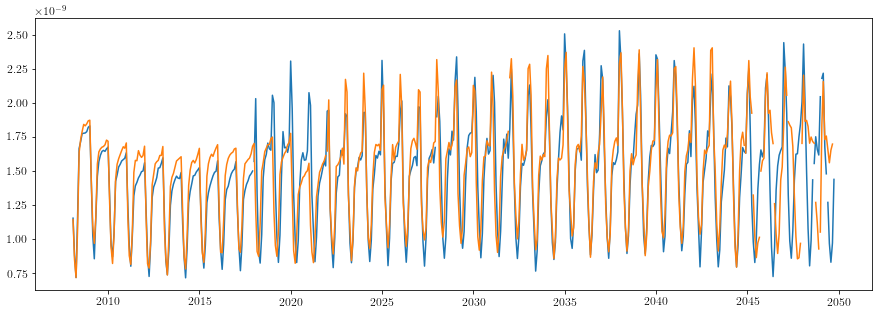

In [209]:
# plt.plot(mwpv2_ts['4km'].time, mwpv2_ts['4km'])
# plt.plot(mwpv2_ts['8km'].time, mwpv2_ts['8km'])


In [212]:
# mwtpv2['4km'].sel(time='2026-01').fbz_mw.where(mwtpv2['4km'].sel(time='2026-01').mwt>100).plot(add_labels=False)

In [213]:
# mwtpv2['4km'].sel(time='2025-12').fbz_mw.where(mwtpv2['4km'].sel(time='2025-12').mwt>100).plot(add_labels=False)

In [214]:
# plt.plot(mwpv2_ts['4km'].sel(time=slice('2025','2027')).time, mwpv2_ts['4km'].sel(time=slice('2025','2027')), 'o--');plt.grid()

In [215]:
# for r in res:
#     plt.plot(mwpv2_ts[r].sel(time=slice('2016','2049')).groupby('time.month').mean(dim='time'), color=colours[r], label=labels[r], linewidth=3, alpha=0.7)
# plt.title(r'$\mathrm{f b_z~in~Mode~Water~Layer~(Climatology)}$')
# plt.legend()
# plt.grid()

In [216]:
# plt.plot(mwpv2_ts['2km'].time, mwpv2_ts['2km'])
# plt.plot(mwpv2_ts['4km'].time, mwpv2_ts['4km'])
# plt.plot(mwpv2_ts['8km'].time, mwpv2_ts['8km'])
# plt.plot(mwpv2_ts['16km'].time, mwpv2_ts['16km'])

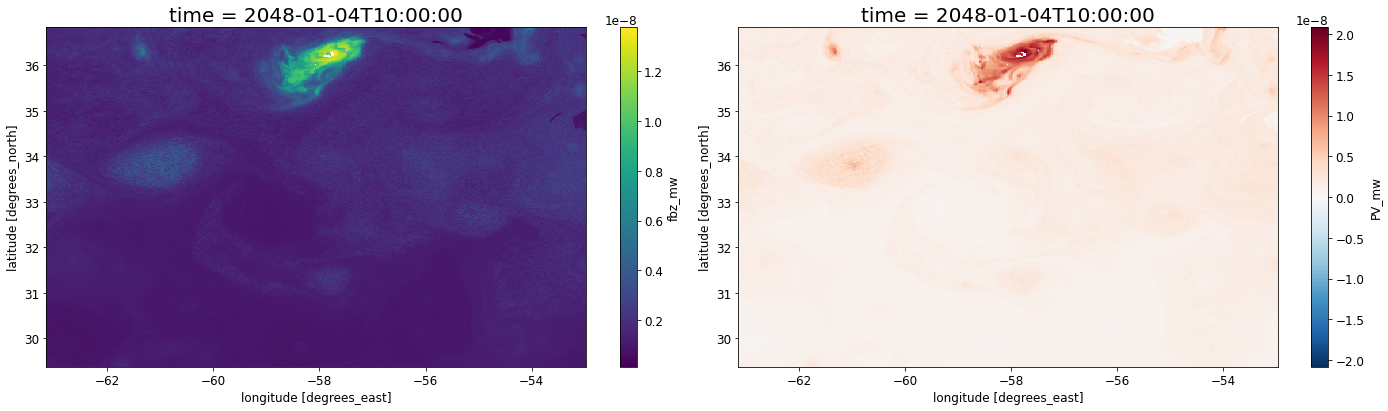

In [24]:
plt.figure(figsize=(20,6), tight_layout=True)
plt.subplot(121)
pvsmall['2km'].isel(time=20).fbz_mw.plot()

plt.subplot(122)
pvsmall['2km'].isel(time=20).PV_mw.plot()


In [13]:
%%time
dirmw2 = '/central/groups/oceanphysics/anirban/modewater2/'

mwtv = {}
for r in res:
    mwtv[r] = xr.open_mfdataset(dirmw2 +r+'_mwthicknessvolume_*.nc')
    print('Modewater full, ' + r)


Modewater full, 2km
Modewater full, 4km
Modewater full, 8km
Modewater full, 16km
CPU times: user 2min, sys: 13.1 s, total: 2min 13s
Wall time: 5min 34s


In [16]:
%%time

pvsmall_ts = {}
mwtv_ts = {}
mwfbz_ts = {}

for r in res:
    pvsmall_ts[r] = pvsmall[r].mean(dim=['XC','YC']).load()
    print('smalldomain timeseries, ', r)
    mwfbz_ts[r] = mwfbz[r].mean(dim=['XC','YC']).load()
    print('monthlymean timeseries, fbz ', r)
    mwtv_ts[r] = mwtv[r].mean(dim=['XC','YC']).load()
    print('monthlymean timeseries, mwt ', r)


smalldomain timeseries,  2km
monthlymean timeseries, fbz  2km
monthlymean timeseries, mwt  2km
smalldomain timeseries,  4km
monthlymean timeseries, fbz  4km
monthlymean timeseries, mwt  4km
smalldomain timeseries,  8km
monthlymean timeseries, fbz  8km
monthlymean timeseries, mwt  8km
smalldomain timeseries,  16km
monthlymean timeseries, fbz  16km
monthlymean timeseries, mwt  16km
CPU times: user 3min 2s, sys: 46.4 s, total: 3min 48s
Wall time: 13min 2s


In [33]:
%%time

mwtv_ts2 = {}
mwfbz_ts2 = {}

for r in res:
    mwfbz_ts2[r] = mwfbz[r].sel(XC=slice(-82,-40)).mean(dim=['XC','YC']).load()
    print('monthlymean timeseries, fbz ', r)
    mwtv_ts2[r] = mwtv[r].sel(XC=slice(-82,-40)).mean(dim=['XC','YC']).load()
    print('monthlymean timeseries, mwt ', r)


monthlymean timeseries, fbz  2km
monthlymean timeseries, mwt  2km
monthlymean timeseries, fbz  4km
monthlymean timeseries, mwt  4km
monthlymean timeseries, fbz  8km
monthlymean timeseries, mwt  8km
monthlymean timeseries, fbz  16km
monthlymean timeseries, mwt  16km
CPU times: user 1min 30s, sys: 19.6 s, total: 1min 49s
Wall time: 9min 54s


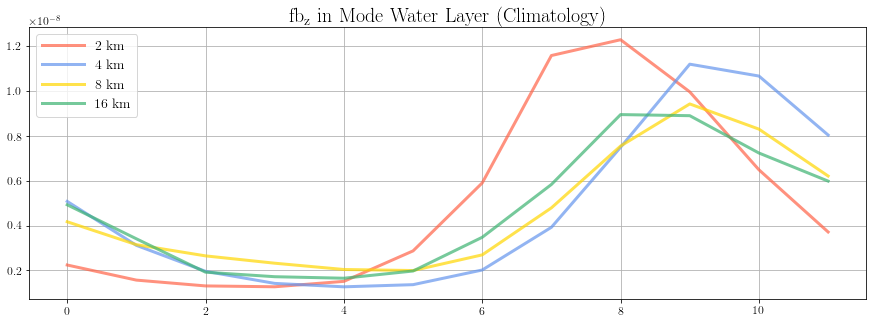

In [43]:
for r in res:
    plt.plot(mwfbz_ts2[r].sel(time=slice('2016','2049')).groupby('time.month').mean(dim='time').fbz_mw, color=colours[r], label=labels[r], linewidth=3, alpha=0.7)
plt.legend()
plt.title(r'$\mathrm{f b_z~in~Mode~Water~Layer~(Climatology)}$')
plt.grid()

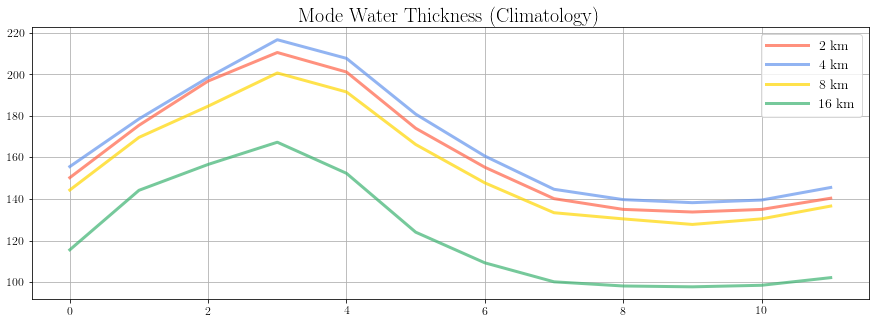

In [44]:
for r in res:
    plt.plot(mwtv_ts2[r].sel(time=slice('2016','2049')).groupby('time.month').mean(dim='time').mwt, color=colours[r], label=labels[r], linewidth=3, alpha=0.7)
plt.legend()
plt.title(r'$\mathrm{Mode~Water~Thickness~(Climatology)}$')
plt.grid()

In [107]:
for r in res:
    print(r, ' mean PV in modewater: ', mwfbz_ts[r].sel(time=slice('2016','2049')).mean(dim='time').fbz_mw.values)


2km  mean PV in modewater:  5.632017434941798e-09
4km  mean PV in modewater:  5.63148170194014e-09
8km  mean PV in modewater:  5.849921567201888e-09
16km  mean PV in modewater:  6.590962098487951e-09


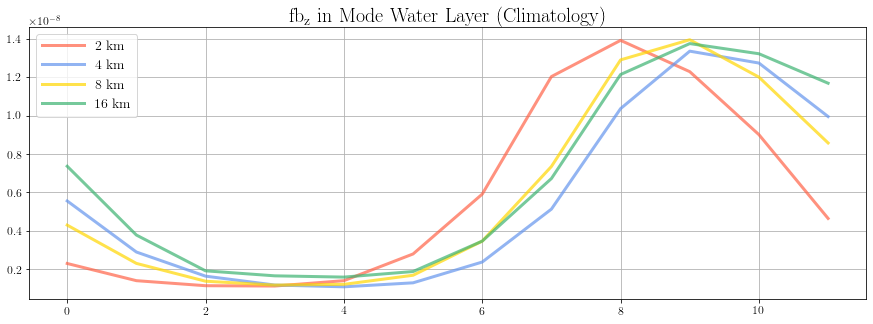

In [101]:
for r in res:
    plt.plot(mwfbz_ts[r].sel(time=slice('2020','2030')).groupby('time.month').mean(dim='time').fbz_mw, color=colours[r], label=labels[r], linewidth=3, alpha=0.7)
plt.title(r'$\mathrm{f b_z~in~Mode~Water~Layer~(Climatology)}$')
plt.legend()
plt.grid()

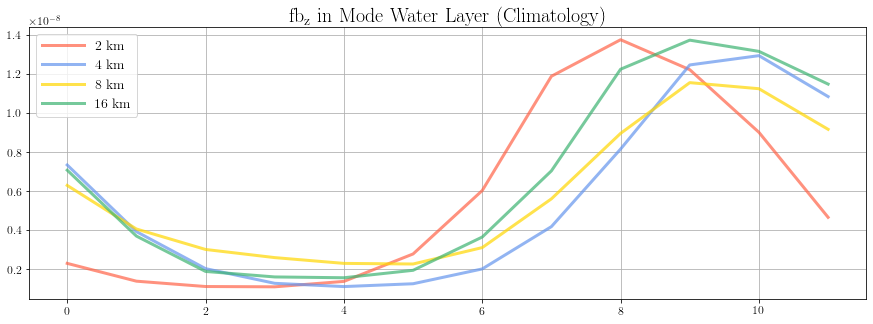

In [45]:
for r in res:
    plt.plot(mwfbz_ts[r].sel(time=slice('2016','2049')).groupby('time.month').mean(dim='time').fbz_mw, color=colours[r], label=labels[r], linewidth=3, alpha=0.7)
plt.title(r'$\mathrm{f b_z~in~Mode~Water~Layer~(Climatology)}$')
plt.legend()
plt.grid()

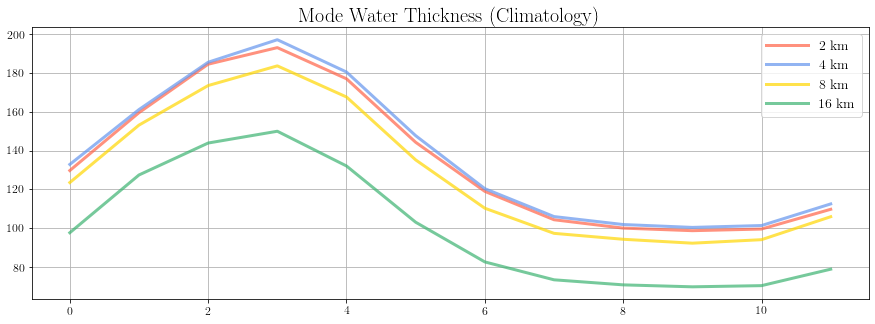

In [46]:
for r in res:
    plt.plot(mwtv_ts[r].sel(time=slice('2016','2049')).groupby('time.month').mean(dim='time').mwt, color=colours[r], label=labels[r], linewidth=3, alpha=0.7)
plt.legend()
plt.title(r'$\mathrm{Mode~Water~Thickness~(Climatology)}$')
plt.grid()

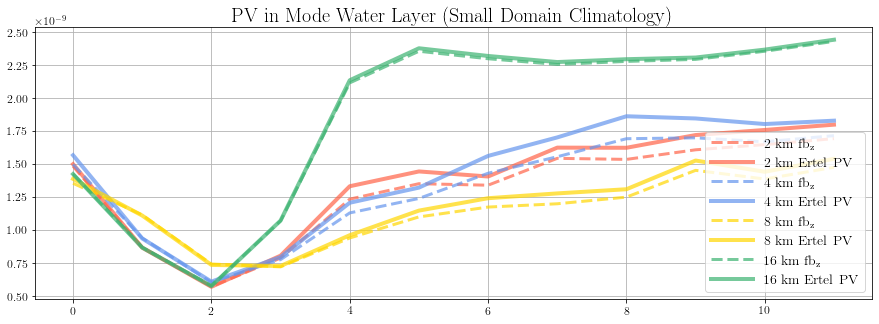

In [49]:
for r in res:
    plt.plot(pvsmall_ts[r].groupby('time.month').mean(dim='time').fbz_mw, color=colours[r], label=labels[r] + r' $\mathrm{fb_z}$', linewidth=3, linestyle='dashed', alpha=0.7)
    plt.plot(pvsmall_ts[r].groupby('time.month').mean(dim='time').PV_mw, color=colours[r], label=labels[r] + r' $\mathrm{Ertel~PV}$', linewidth=4, alpha=0.7)
plt.title(r'$\mathrm{PV~in~Mode~Water~Layer~(Small~Domain~Climatology)}$')
plt.legend()
plt.grid()

In [80]:
%%time
# mwpv_ts = {}
# mwpv_ts_small = {}
for r in res:
    mwfbz_ts[r].to_netcdf(dirmw2+r+'_modewater_fbz_timeseries_full.nc')
    mwfbz_ts2[r].to_netcdf(dirmw2+r+'_modewater_fbz_timeseries_8240.nc')
    pvsmall_ts[r].to_netcdf(dirmw2+r+'_smalldomain_highfreq_pv_timeseries.nc')

CPU times: user 105 ms, sys: 25.1 ms, total: 130 ms
Wall time: 202 ms


In [22]:
colours = {'2km': color1, '4km': color2, '8km': color4, '16km': color3, 'eccov4r4':  color5}
labels = {'2km': r'$\mathrm{2~km}$', '4km': r'$\mathrm{4~km}$', '8km': r'$\mathrm{8~km}$', '16km': r'$\mathrm{16~km}$','eccov4r4': r'$\mathrm{ECCO~v4r4}$', }

In [92]:
# mpl.rcParams['text.usetex'] = False


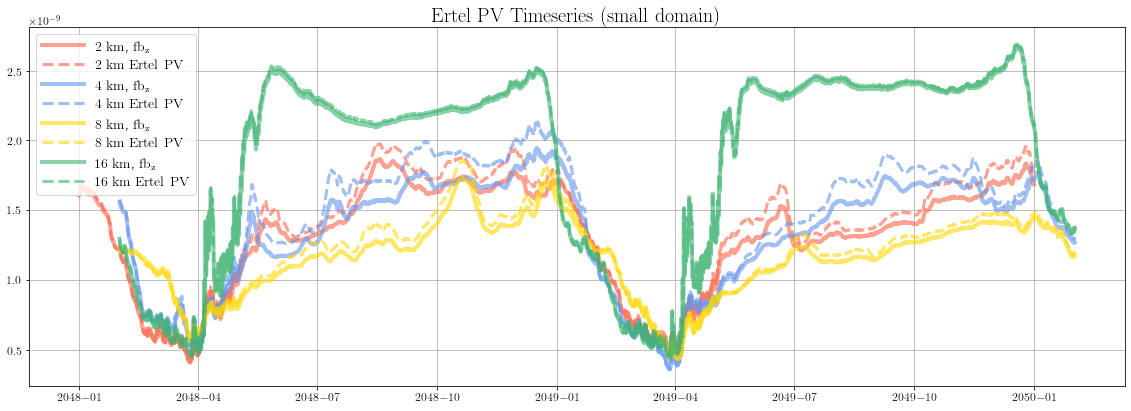

In [110]:
plt.figure(figsize=(16,6), tight_layout=True)
for i, r in enumerate(res):
    plt.plot(pvsmall_ts[r].time, pvsmall_ts[r].fbz_mw, color=colours[r], linewidth=4, alpha=0.6, label=labels[r]+ r', $\mathrm{f b_z}$')
    plt.plot(pvsmall_ts[r].time, pvsmall_ts[r].PV_mw, color=colours[r], linewidth=3, linestyle='dashed', alpha=0.6, label=labels[r] + r' $\mathrm{Ertel~PV}$')
plt.legend()
plt.title(r'$\mathrm{Ertel~PV~Timeseries~(small~domain)}$')
plt.grid()
    
#     plt.subplot(412)
#     mwfbz_ts[r].fbz_mw.plot(color=colours[r], linewidth=4, alpha=0.6, label=labels[r])
#     plt.legend()
#     plt.title(r'Timeseries (monthly mean) $f b_z$')
#     plt.grid()
    
#     plt.subplot(413)
#     mwtv_ts[r].mwt.plot(color=colours[r], linewidth=4, alpha=0.6, label=labels[r])
#     plt.legend()
#     plt.title(r'Timeseries (monthly mean) Mode Water Thickness')
#     plt.grid()
    
#     plt.subplot(414)
#     mwtv_ts[r].mwv.plot(color=colours[r], linewidth=4, alpha=0.6, label=labels[r])
#     plt.legend()
#     plt.title(r'Timeseries (monthly mean) Mode Water Volume')
#     plt.grid()
    
    


In [55]:
# pvsmall_tm = {}
mwtv_tm = {}
mwfbz_tm = {}
for r in res:
    mwtv_tm[r] = mwtv[r].sel(time=slice('2016','2049')).mean(dim='time').load()
    print('MW T, V, '+ r)
    mwfbz_tm[r] = mwfbz[r].sel(time=slice('2016','2049')).mean(dim='time').load()
    print('MW PV, '+ r)


/central/groups/oceanphysics/anirban/miniconda/envs/myenvironment2/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


MW T, V, 2km


/central/groups/oceanphysics/anirban/miniconda/envs/myenvironment2/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


MW PV, 2km


/central/groups/oceanphysics/anirban/miniconda/envs/myenvironment2/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


MW T, V, 4km


/central/groups/oceanphysics/anirban/miniconda/envs/myenvironment2/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


MW PV, 4km


/central/groups/oceanphysics/anirban/miniconda/envs/myenvironment2/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


MW T, V, 8km


/central/groups/oceanphysics/anirban/miniconda/envs/myenvironment2/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


MW PV, 8km


/central/groups/oceanphysics/anirban/miniconda/envs/myenvironment2/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


MW T, V, 16km
MW PV, 16km


/central/groups/oceanphysics/anirban/miniconda/envs/myenvironment2/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


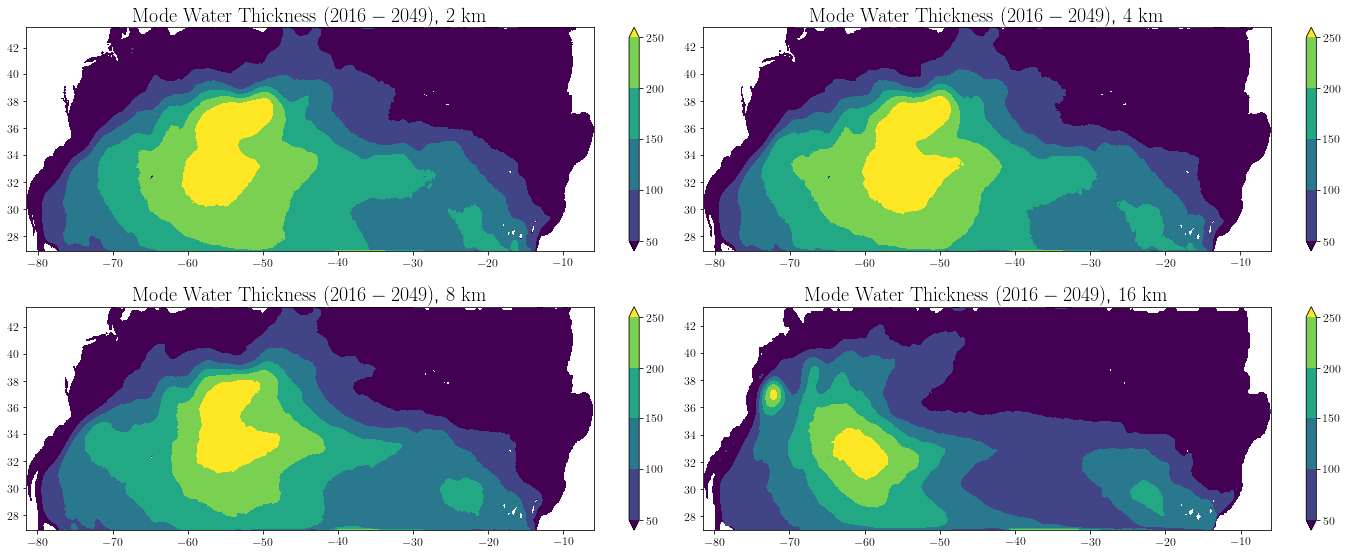

In [61]:
plt.figure(figsize=(20,8), tight_layout=True)
for i, r in enumerate(res):
    plt.subplot(2,2,i+1)
    mwtv_tm[r].mwt.plot.contourf(levels=np.arange(50,300,50), add_labels=False)
    plt.title(r'$\mathrm{Mode~Water~Thickness~(2016-2049)}$, '+ labels[r])

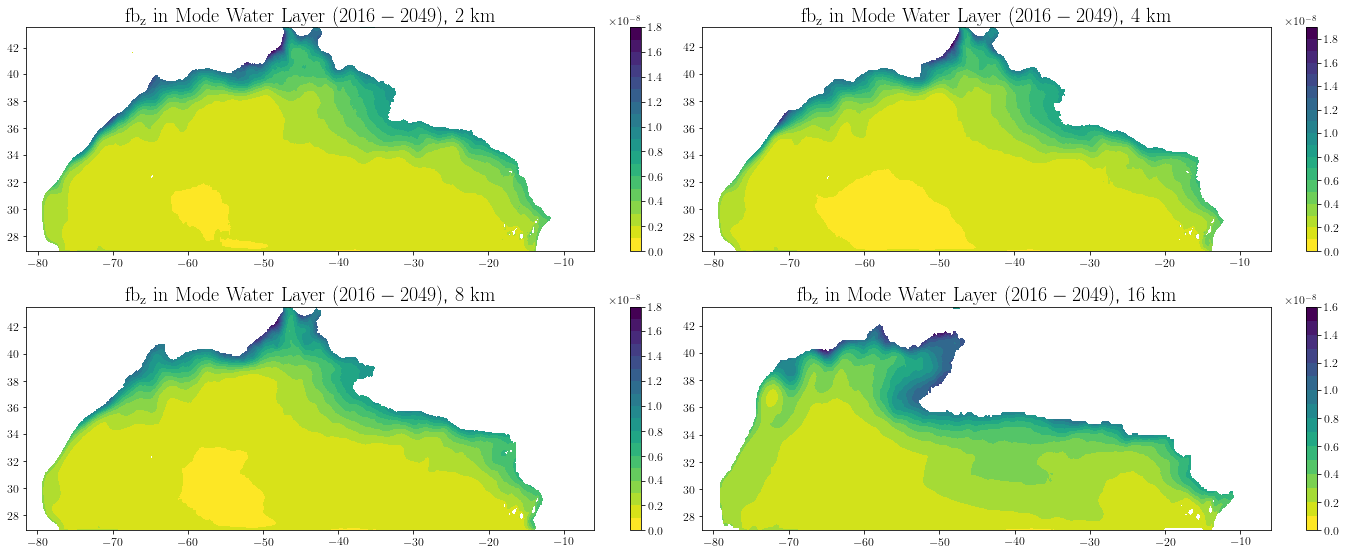

In [67]:
plt.figure(figsize=(20,8), tight_layout=True)
for i, r in enumerate(res):
    plt.subplot(2,2,i+1)
    mwfbz_tm[r].fbz_mw.where(mwtv_tm[r].mwt>50).plot.contourf(levels=20, cmap='viridis_r', add_labels=False)
    plt.title(r'$\mathrm{f b_z~in~Mode~Water~Layer~(2016-2049)}$, '+ labels[r])

In [69]:
%%time

mwtvpv_tm = {}
for r in res:
    mwtvpv_tm[r] = xr.merge([mwtv_tm[r],mwfbz_tm[r]])
    mwtvpv_tm[r].to_netcdf(dirmw2 + r+'_modewater_timemean.nc')

CPU times: user 189 ms, sys: 73.5 ms, total: 263 ms
Wall time: 658 ms


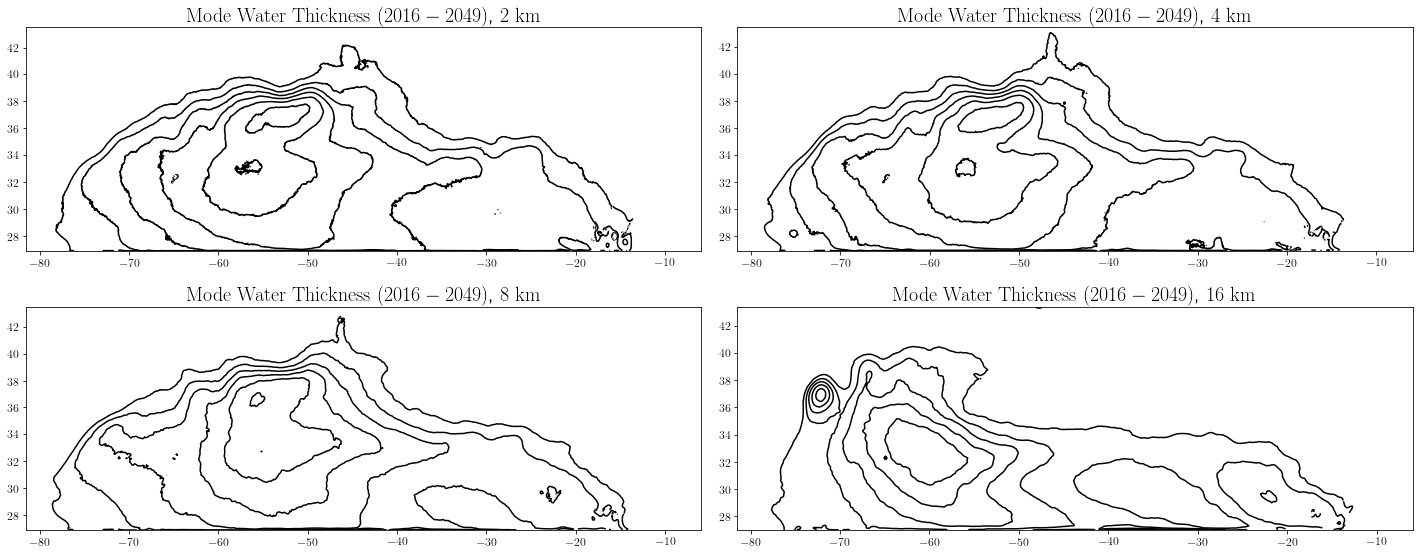

In [75]:
plt.figure(figsize=(20,8), tight_layout=True)
for i, r in enumerate(res):
    plt.subplot(2,2,i+1)
    mwtvpv_tm[r].mwt.where(mwtvpv_tm[r].mwt>50).plot.contour(levels=np.arange(40,350,40), colors = 'k', add_labels=False)
    plt.title(r'$\mathrm{Mode~Water~Thickness~(2016-2049)}$, '+ labels[r])

In [14]:
%%time
dirsnapm = '/central/groups/oceanphysics/anirban/NA_monthly_snaps/'
dir_runm = ['ll2960/diags_snap','ll1480/diags_snap', 'll740/diags_snap', 'll370/diags_snap']
zlevels = np.array([1., 2., 3., 4., 5., 6., 7., 8., 9.,10.,11.,13.,15.,
                    17.,19.,21.,23.,25.,27.,29.,31.,33.,35.,37.,39.,41.,43.,45.,
                    47.,49.,51.,53.,55.,57.,59.,61.,63.,65.,67.,69.,71.,73.,75.,
                    77.,79.,81.,83.,85.,87.,89.,91.,93.,95.,97.,99.,])
zlevels = (zlevels -1).astype(int)

ds_surf = {}
grids_surf = {}
Ts = {}
cross_spec = {}
KE_spec = {}
bp_spec = {}
iso_spec = {}
timeseries = {}

for i,r in enumerate(res):
    ds_surf[r] = xmitgcm.open_mdsdataset(data_dir=dirsnapm+dir_runm[i], grid_dir=dir_grid[i], 
                                    read_grid=False, delta_t=deltaT[i], nz = 55, prefix='monthly_snap', iters= 'all',
                                    ref_date='2008-1-1 0:0:0').sel(time='2049-02').isel(k=0,k_l=0,k_u=0).drop(['k_p1'])
    grids_surf[r] = grids[r].isel(Z = zlevels[0], Zl = zlevels[0], Zu = zlevels[0], Zp1 = zlevels[0],).drop(['Zp1'])
    Ts[r] = ds_surf[r].isel(time=0).THETA.values
    print('Reading monthly snaps, ' + r)
    cross_spec[r] = xr.open_mfdataset(dirroot_s+r+'/%s_crossspectra_*.nc' %r)
    KE_spec[r] = xr.open_mfdataset(dirroot_s+r+'/%s_KEspectra_*.nc' %r)
    bp_spec[r] = xr.open_mfdataset(dirroot_s+r+'/%s_bp_spectra_*.nc' %r)
    timeseries[r] = xr.open_dataset(dirroot_s+'timeseries/'+'%s_timeseries.nc' %r)
    iso_spec[r] = xr.merge([KE_spec[r], bp_spec[r], cross_spec[r]])
    print('Reading timeseries + spectra, ' + r)


Reading monthly snaps, 2km
Reading timeseries + spectra, 2km
Reading monthly snaps, 4km
Reading timeseries + spectra, 4km
Reading monthly snaps, 8km
Reading timeseries + spectra, 8km
Reading monthly snaps, 16km
Reading timeseries + spectra, 16km
CPU times: user 1min 33s, sys: 4.08 s, total: 1min 37s
Wall time: 4min 16s


In [15]:
T_decor = {'2km': 43.58, '4km': 43.58 , '8km': 42.83, '16km': 48.00}
T_decor_e = {'2km': 12.58, '4km': 13.25, '8km': 14.33, '16km': 17.17}

for r in res:
    print('Decorrelation time (days), %s: (1 -> 0) = %3.2f ; (e-folding) = %3.2f' %(r,T_decor[r],T_decor_e[r]))

Decorrelation time (days), 2km: (1 -> 0) = 43.58 ; (e-folding) = 12.58
Decorrelation time (days), 4km: (1 -> 0) = 43.58 ; (e-folding) = 13.25
Decorrelation time (days), 8km: (1 -> 0) = 42.83 ; (e-folding) = 14.33
Decorrelation time (days), 16km: (1 -> 0) = 48.00 ; (e-folding) = 17.17


In [16]:
N_deg = {}
N_deg_e = {}
for r in res:
    N_deg[r] = int(round((len(timeseries[r].time)/6) / T_decor[r]))
    N_deg_e[r] = int(round((len(timeseries[r].time)/6) / T_decor_e[r]))
    print('N (degrees of freedom), %s: = %s, %s (e-folding) ' %(r,N_deg[r],N_deg_e[r]))


N (degrees of freedom), 2km: = 17, 58 (e-folding) 
N (degrees of freedom), 4km: = 17, 55 (e-folding) 
N (degrees of freedom), 8km: = 17, 51 (e-folding) 
N (degrees of freedom), 16km: = 15, 43 (e-folding) 


In [17]:
X_tot = {}
Y_tot = {}
Ndeg_s = {}
X_peak = (3.5e-6)**-1
Y_peak = (3.5e-6)**-1

for r in res:
    X_tot[r] = grids2[r].dxC.sum(dim='XG').mean(dim='YC').values
    Y_tot[r] = grids2[r].dyC.sum(dim='YG').mean(dim='XC').values
    Ndeg_s[r] = int(round(X_tot[r]*Y_tot[r]/(X_peak*Y_peak)))
    print('N(X) (degrees of freedom, spatial), %s: = %s' %(r,Ndeg_s[r]))

N(X) (degrees of freedom, spatial), 2km: = 10
N(X) (degrees of freedom, spatial), 4km: = 10
N(X) (degrees of freedom, spatial), 8km: = 10
N(X) (degrees of freedom, spatial), 16km: = 10


In [18]:
def calc_mean_std_from_timeseries(ts):
    varlist = ['wpbp','Upbp_gradb','gradb','b_z','b_x','b_y','bvar','wp2']
    
    mstd = xr.merge([xr.merge([ts[v].std(dim='time').to_dataset(name=v+'_s') for v in varlist]) , 
                         xr.merge([ts[v].mean(dim='time').to_dataset(name=v+'_m') for v in varlist])])
    return mstd

def plus_minus_sdlog(da):
    arr_m = np.log10(da.mean(dim=['time','Z']))
    arr_sd = (np.log10(da)).std(dim=['time','Z'])
    arr_l = arr_m - arr_sd
    arr_u = arr_m + arr_sd
    return (arr_m, arr_l, arr_u)


In [19]:
%%time

mean_std = {}

keiso_m100 = {}
keiso_l100 = {}
keiso_u100 = {}

bpiso_m100 = {}
bpiso_l100 = {}
bpiso_u100 = {}

for r in res:
    mean_std[r] = calc_mean_std_from_timeseries(timeseries[r])
    
    keiso_m100[r], keiso_l100[r], keiso_u100[r] = plus_minus_sdlog(iso_spec[r].keiso.sel(Z=slice(0,-100)))
    bpiso_m100[r], bpiso_l100[r], bpiso_u100[r] = plus_minus_sdlog(iso_spec[r].bphat_iso.sel(Z=slice(0,-100)))
    
    keiso_m100[r] = keiso_m100[r].load()
    keiso_l100[r] = keiso_l100[r].load()
    keiso_u100[r] = keiso_u100[r].load()
    
    bpiso_m100[r] = bpiso_m100[r].load()
    bpiso_l100[r] = bpiso_l100[r].load()
    bpiso_u100[r] = bpiso_u100[r].load()

/central/groups/oceanphysics/anirban/miniconda/envs/myenvironment2/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/central/groups/oceanphysics/anirban/miniconda/envs/myenvironment2/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/central/groups/oceanphysics/anirban/miniconda/envs/myenvironment2/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/central/groups/oceanphysics/anirban/miniconda/envs/myenvironment2/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


CPU times: user 1min 14s, sys: 9.45 s, total: 1min 24s
Wall time: 2min 38s


In [20]:
figdir = 'figs_paper_Aug2021/'

/central/groups/oceanphysics/anirban/miniconda/envs/myenvironment2/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: The 'nonposx' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
/central/groups/oceanphysics/anirban/miniconda/envs/myenvironment2/lib/python3.7/site-packages/ipykernel_launcher.py:52: MatplotlibDeprecationWarning: The 'nonposx' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.


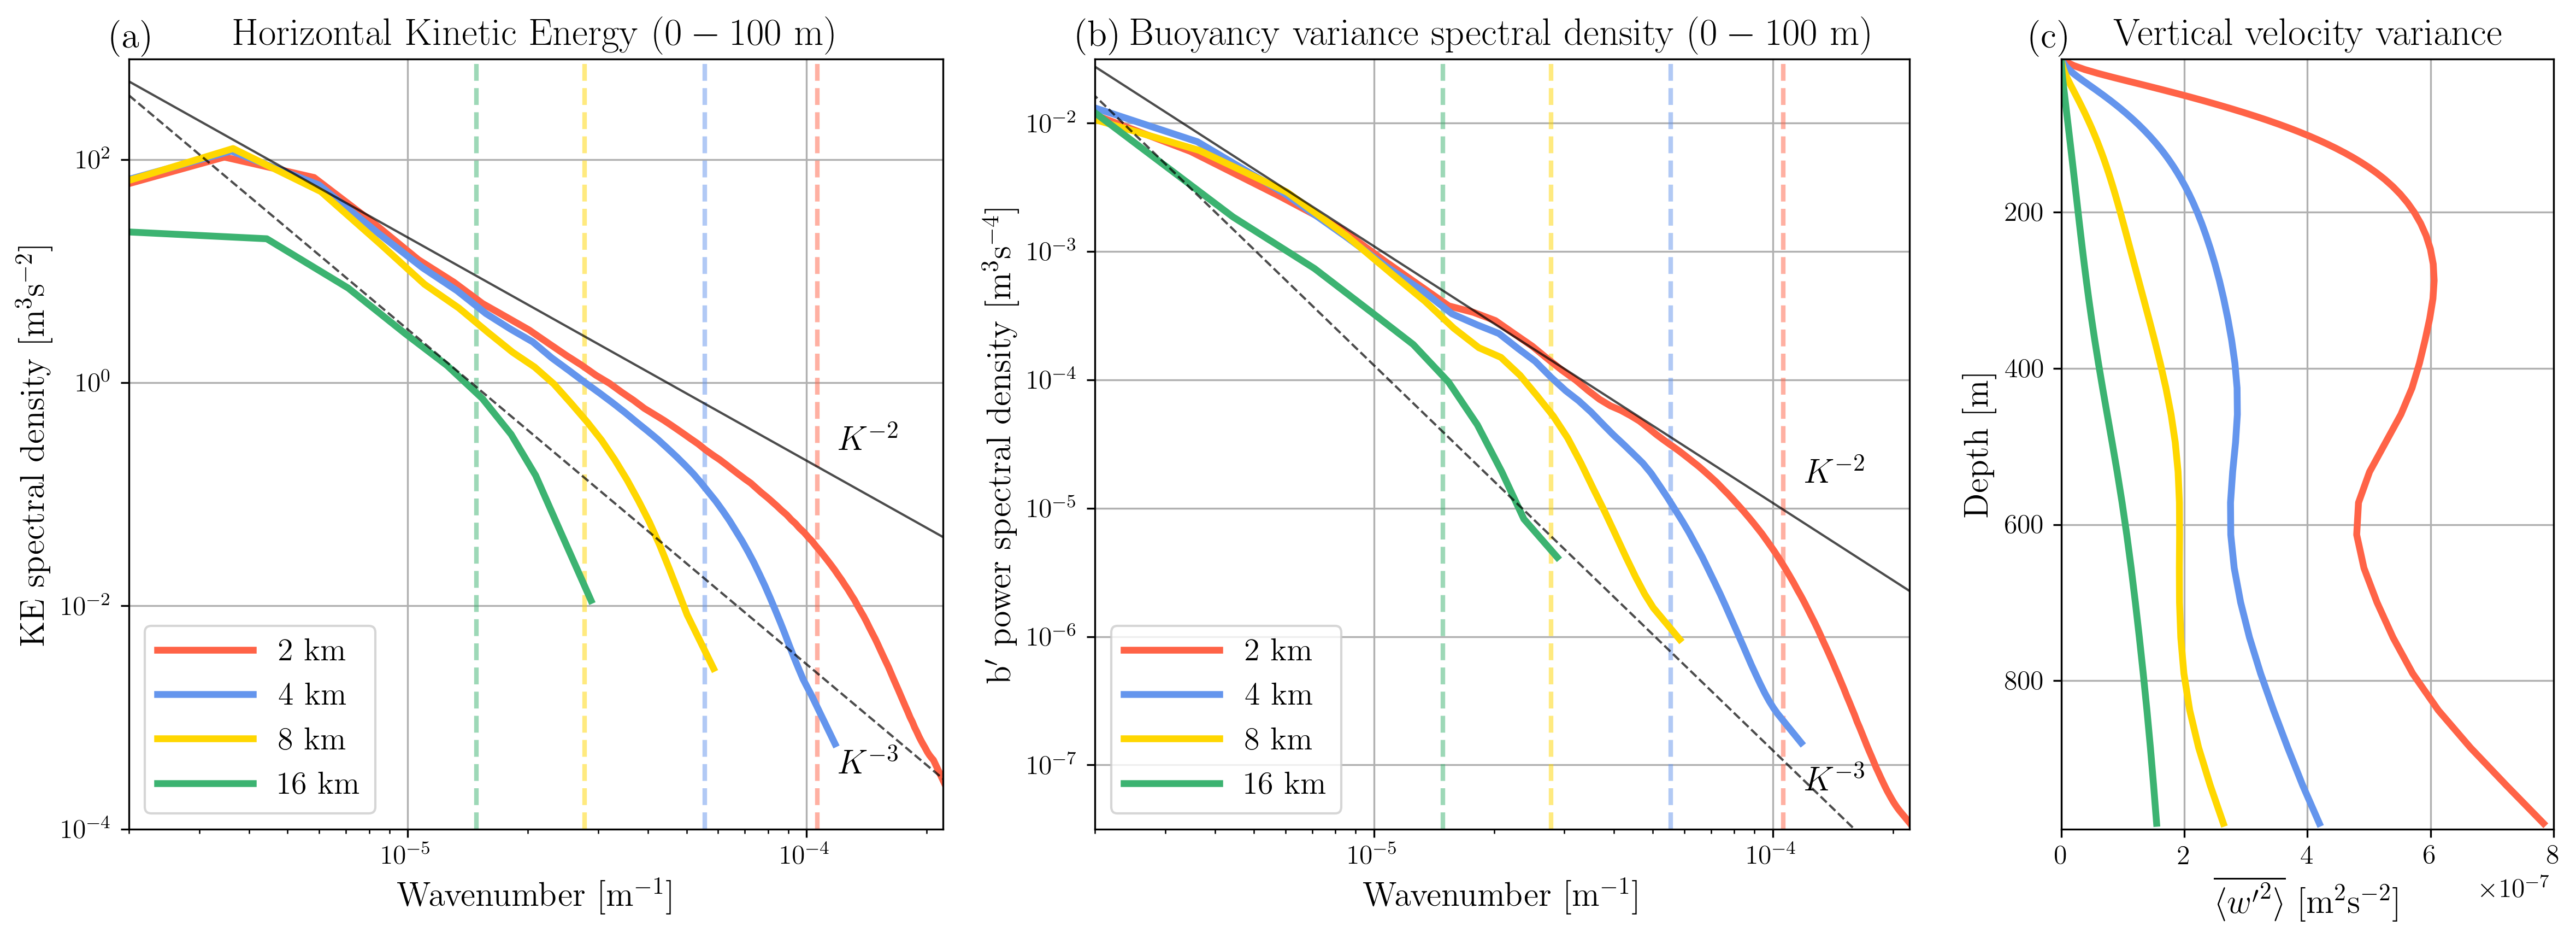

In [23]:
fig = plt.figure(figsize=(16,6), dpi=300)
gs = gridspec.GridSpec(ncols=8, nrows=1, figure=fig)

ax1 = fig.add_subplot(gs[0, 0:3])

ks = keiso_m100['2km'].freq_r
Es2 = 2e-9*keiso_m100['2km'].freq_r**-2
Es3 = 3e-15*keiso_m100['2km'].freq_r**-3

for i, r in enumerate(res):
    ax1.plot(keiso_m100[r].freq_r, keiso_m100[r], linewidth=3, color = colors[i], label = labels[r])    
plt.legend(fontsize=14, loc='lower left')

ax1.plot(ks,np.log10(Es2),'-', color='k',linewidth=1,alpha=.7)
ax1.plot(ks,np.log10(Es3),'--', color='k',linewidth=1,alpha=.7)
ax1.text(1.2e-4, -0.6, r'$K^{-2}$', fontsize=15)
ax1.text(1.2e-4, -3.5, r'$K^{-3}$', fontsize=15)
plt.title(r'$\mathrm{Horizontal~Kinetic~Energy}$ $\mathrm{(0-100~m)}$', fontsize=17)
ax1.set_xscale('log', nonposx='mask')
ax1.set_ylim([-4,2.9])
ax1.set_xlim([2e-6,2.2e-4])
ax1.text(1.8e-6, 3, r'$\mathrm{(a)}$')
ax1.vlines((4.7*2e3)**-1, -4,2.9, linewidth=2, linestyle='dashed', alpha=0.5, color=color1)
ax1.vlines((4.5*4e3)**-1, -4,2.9, linewidth=2, linestyle='dashed', alpha=0.5, color=color2)
ax1.vlines((4.5*8e3)**-1, -4,2.9, linewidth=2, linestyle='dashed', alpha=0.5, color=color4)
ax1.vlines((4.2*16e3)**-1, -4,2.9, linewidth=2, linestyle='dashed', alpha=0.5, color=color3)
    
ax1.set_xlabel(r'$\mathrm{Wavenumber}$ $[\mathrm{m^{-1}}]$', fontsize=15)
ax1.set_ylabel(r'$\mathrm{KE~spectral~density}$  $[\mathrm{m^{3}s^{-2}}]$', fontsize=15)

tck = np.array([-4,-2,0,2])
tcklbl =['$10^{-4}$', '$10^{-2}$','$10^{0}$','$10^{2}$', ]
ax1.set_yticks(tck)
ax1.set_yticklabels(tcklbl)
plt.grid()

ax2 = fig.add_subplot(gs[0, 3:6])

ks = keiso_m100['2km'].freq_r
Es2 = 1.1e-13*keiso_m100['2km'].freq_r**-2
Es3 = 1.3e-19*keiso_m100['2km'].freq_r**-3

for i, r in enumerate(res):
    ax2.plot(bpiso_m100[r].freq_r, bpiso_m100[r], linewidth=3, color = colors[i], label = labels[r])    
plt.legend(fontsize=14, loc='lower left')

ax2.plot(ks,np.log10(Es2),'-', color='k',linewidth=1,alpha=.7)
ax2.plot(ks,np.log10(Es3),'--', color='k',linewidth=1,alpha=.7)
ax2.text(1.2e-4, -4.8, r'$K^{-2}$', fontsize=15)
ax2.text(1.2e-4, -7.2, r'$K^{-3}$', fontsize=15)
plt.title(r'$\mathrm{Buoyancy~variance~spectral~density}$ $\mathrm{(0-100~m)}$', fontsize=17)
ax2.set_xscale('log', nonposx='mask')
ax2.set_ylim([-7.5,-1.5])
ax2.set_xlim([2e-6,2.2e-4])
ax2.vlines((4.7*2e3)**-1, -7.5,-1.5, linewidth=2, linestyle='dashed', alpha=0.5, color=color1)
ax2.vlines((4.5*4e3)**-1, -7.5,-1.5, linewidth=2, linestyle='dashed', alpha=0.5, color=color2)
ax2.vlines((4.5*8e3)**-1, -7.5,-1.5, linewidth=2, linestyle='dashed', alpha=0.5, color=color4)
ax2.vlines((4.2*16e3)**-1, -7.5,-1.5, linewidth=2, linestyle='dashed', alpha=0.5, color=color3)

ax2.text(1.8e-6, -1.4, r'$\mathrm{(b)}$')

ax2.set_xlabel(r'$\mathrm{Wavenumber}$ $[\mathrm{m^{-1}}]$', fontsize=15)
ax2.set_ylabel(r'$\mathrm{b^{\prime}~power~spectral~density}$  $[\mathrm{m^{3}s^{-4}}]$', fontsize=15)

tck2 = np.array([-7,-6,-5,-4,-3,-2])
tcklbl2 =['$10^{-7}$','$10^{-6}$','$10^{-5}$','$10^{-4}$','$10^{-3}$','$10^{-2}$', ]
ax2.set_yticks(tck2)
ax2.set_yticklabels(tcklbl2)
plt.grid()



ax3 = fig.add_subplot(gs[0, -2:])
for i,r in enumerate(res):
    
    ax3.plot(mean_std[r].wp2_m, mean_std[r].Z, linewidth=3, color = colors[i],label=labels[r])
    ax3.set_ylim([-990,-4])
    ax3.set_yticks([-200,-400,-600,-800])
    ax3.set_yticklabels([r'$200$',r'$400$',r'$600$',r'$800$'])
    ax3.set_xlim([0,8e-7])
    ax3.set_ylabel(r'$\mathrm{Depth}$ $[\mathrm{m}]$', fontsize=15)
    ax3.set_xlabel(r'$\overline{\langle {w^{\prime}}^2 \rangle}$  $[\mathrm{m^{2}s^{-2}}]$', fontsize=15)
    plt.title(r'$\mathrm{Vertical~velocity~variance}$' , fontsize=17)
ax3.text(-5e-8, 10, r'$\mathrm{(c)}$')
# plt.legend(fontsize=12, loc=5, framealpha=0.5)
plt.grid()
plt.tight_layout()

fig.savefig(figdir + 'KEspec_bpspec_wp2_noerrbar')
fig.savefig(figdir + 'KEspec_bpspec_wp2_noerrbar.pdf', dpi=200)

In [26]:
dz = np.array([5.00,   5.00,   5.00,   5.00,   5.00,   5.00,   5.00,   5.00,   5.00,
          5.00,   5.00,   5.00,   5.00,   5.00,   5.00,   5.01,   5.01,   5.02,
          5.04,   5.07,   5.12,   5.20,   5.31,   5.49,   5.72,   6.04,   6.45,
          6.97,   7.62,   8.42,   9.36,  10.46,  11.72,  13.13,  14.70,  16.40,
         18.24,  20.18,  22.21,  24.29,  26.43,  28.57,  30.71,  32.79,  34.82,
         36.76,  38.60,  40.30,  41.87,  43.28,  44.54,  45.64,  46.58,  47.38,
         48.03,  48.55,  48.96,  49.29,  49.53,  49.72,  49.90,  50.11,  50.41,
         50.92,  51.69,  52.87,  54.54,  56.79,  59.67,  63.16,  67.26,  71.83,
         76.83,  82.11,  87.61,  93.22,  98.91, 104.64, 110.38, 116.12, 121.87,
        127.63, 133.38, 139.12, 144.87, 150.63, 156.38, 162.12, 167.87, 173.63,
        179.38, 185.12, 190.87, 196.63, 202.38, 208.12, 213.87, 219.63, 225.38,
        231.12,])
zt = np.zeros_like(dz)[]
zb = np.zeros_like(dz) + -2.5
zt = zt + np.cumsum(dz*-1)
z = np.cumsum(dz*-1)


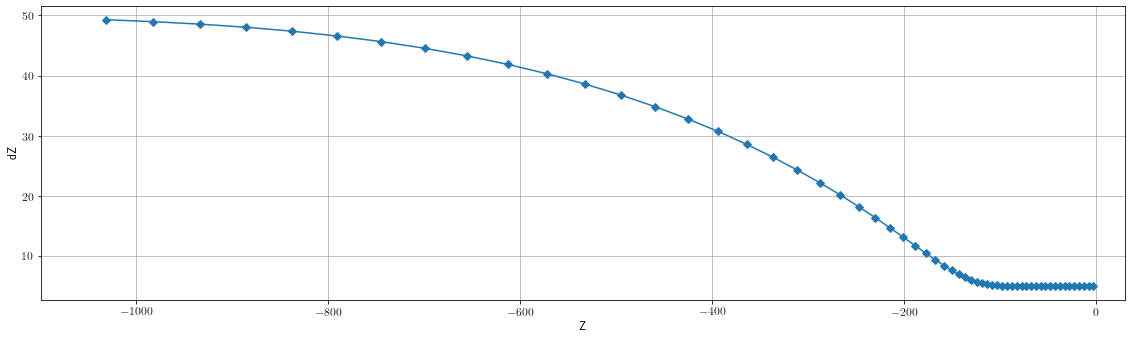

In [43]:
plt.figure(figsize=(16,5), tight_layout=True)
plt.plot(grids['2km'].Z[0:58], grids['2km'].drF[0:58], 'D-')
plt.xlabel('Z')
plt.ylabel('dZ')
plt.xlim([-1100,30])
plt.grid()

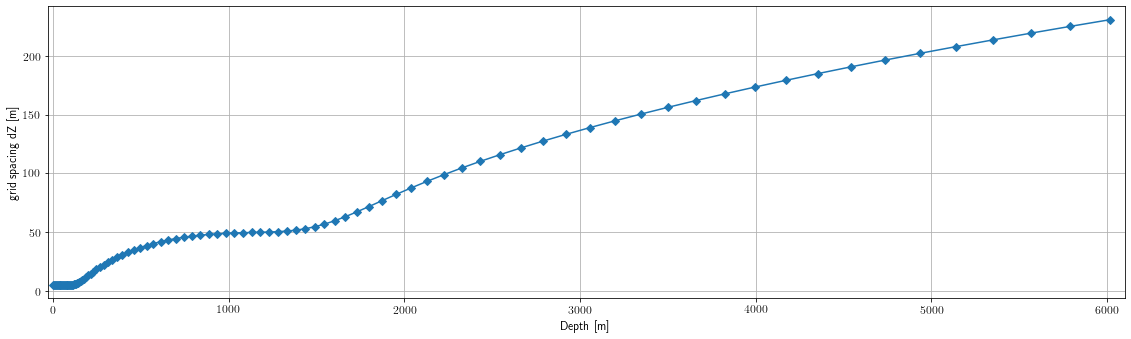

In [46]:
plt.figure(figsize=(16,5), tight_layout=True)
plt.plot(-grids['2km'].Z, grids['2km'].drF, 'D-')
plt.xlabel('Depth [m]')
plt.ylabel('grid spacing dZ [m]')
plt.xlim([-30,6100])
plt.grid()

In [29]:
np.roll(dz,1)

array([231.12,   5.  ,   5.  ,   5.  ,   5.  ,   5.  ,   5.  ,   5.  ,
         5.  ,   5.  ,   5.  ,   5.  ,   5.  ,   5.  ,   5.  ,   5.  ,
         5.01,   5.01,   5.02,   5.04,   5.07,   5.12,   5.2 ,   5.31,
         5.49,   5.72,   6.04,   6.45,   6.97,   7.62,   8.42,   9.36,
        10.46,  11.72,  13.13,  14.7 ,  16.4 ,  18.24,  20.18,  22.21,
        24.29,  26.43,  28.57,  30.71,  32.79,  34.82,  36.76,  38.6 ,
        40.3 ,  41.87,  43.28,  44.54,  45.64,  46.58,  47.38,  48.03,
        48.55,  48.96,  49.29,  49.53,  49.72,  49.9 ,  50.11,  50.41,
        50.92,  51.69,  52.87,  54.54,  56.79,  59.67,  63.16,  67.26,
        71.83,  76.83,  82.11,  87.61,  93.22,  98.91, 104.64, 110.38,
       116.12, 121.87, 127.63, 133.38, 139.12, 144.87, 150.63, 156.38,
       162.12, 167.87, 173.63, 179.38, 185.12, 190.87, 196.63, 202.38,
       208.12, 213.87, 219.63, 225.38])

In [138]:
T67['eccov4r4'] = T67['eccov4r4'].mean(dim='time')
T64['eccov4r4'] = T64['eccov4r4'].mean(dim='time')
T55['eccov4r4'] = T55['eccov4r4'].mean(dim='time')
T52['eccov4r4'] = T52['eccov4r4'].mean(dim='time')

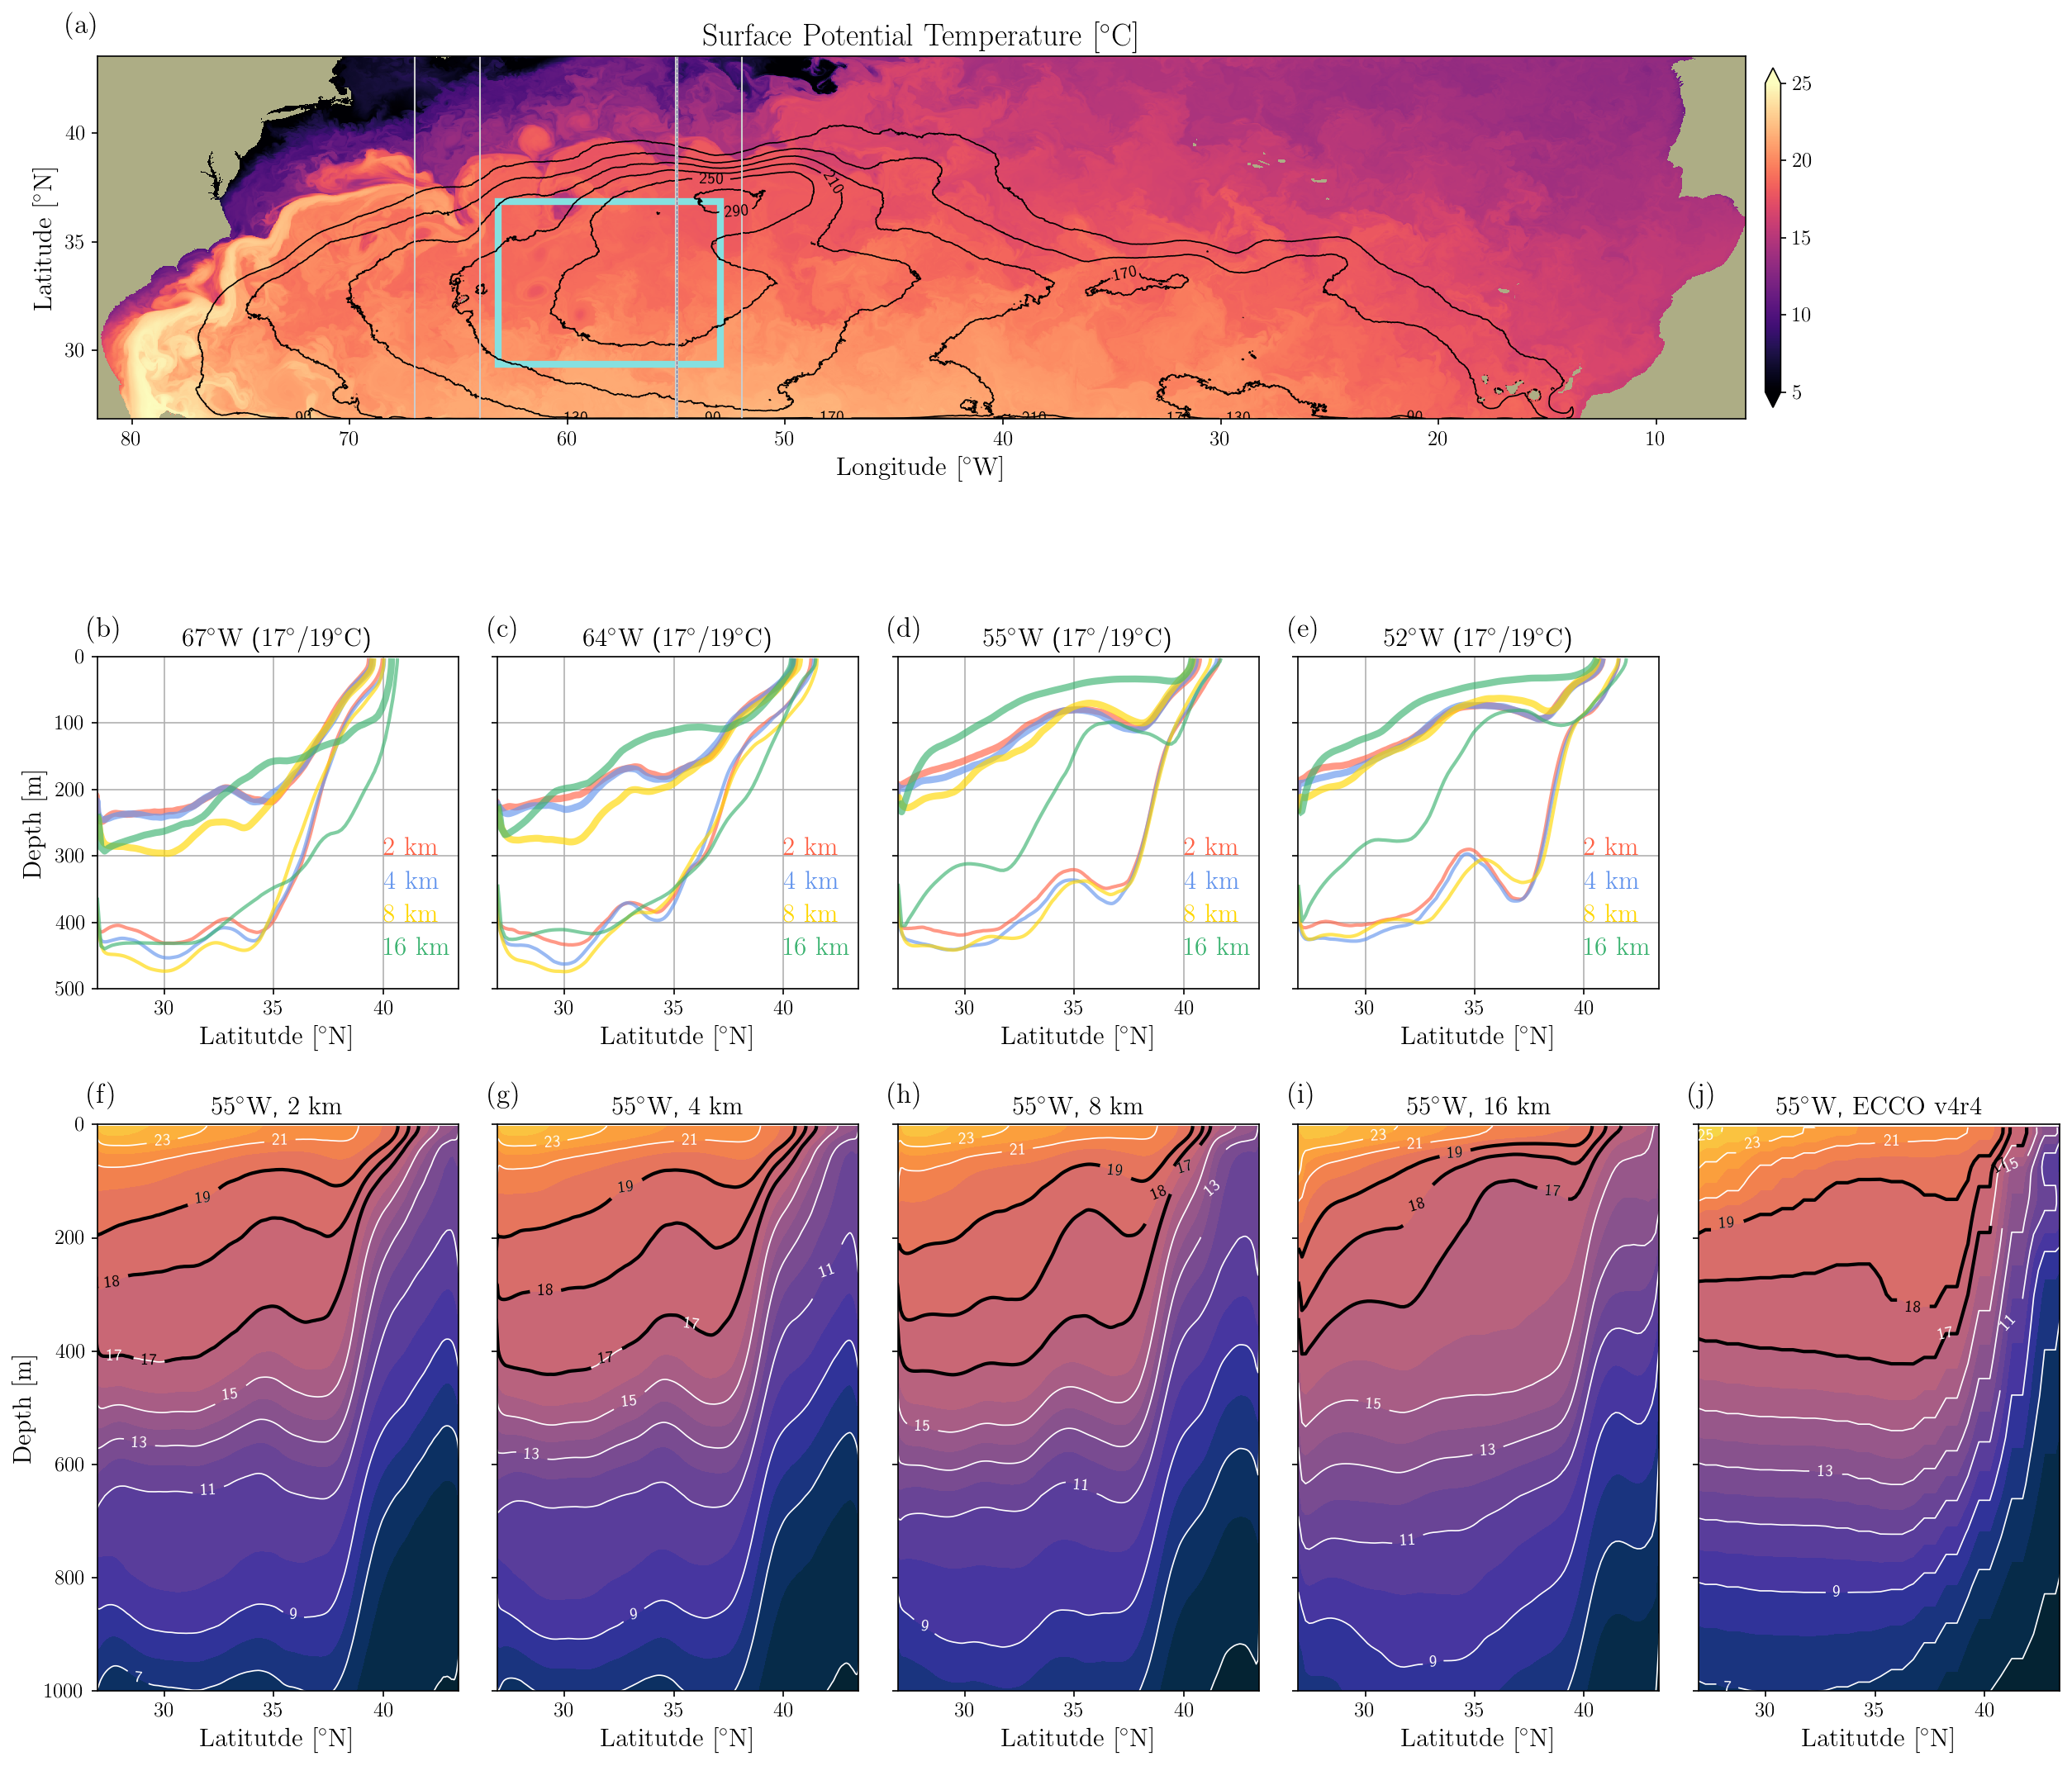

In [152]:
fig = plt.figure(figsize=(17,15), dpi=150, tight_layout=True)
plt.subplot2grid((8,5),(0,0), rowspan=3, colspan=5)

plt.pcolormesh(x['2km'],y['2km'],Ts['2km'],vmin=5, vmax=25,cmap='magma', shading='auto', rasterized=True);
plt.xlabel(r'$\mathrm{Longitude~[^{\circ}W]}$', fontsize=15)
plt.ylabel(r'$\mathrm{Latitude~[^{\circ}N]}$', fontsize=15);
plt.title(r'$\mathrm{Surface~Potential~Temperature~[^{\circ} C]}$', fontsize=18)
plt.colorbar(shrink=0.6, pad = 0.01, extend='both', ticks = [5,10,15,20,25])
csx=mwtvpv_tm['2km'].mwt.where(mwtvpv_tm['2km'].mwt>50).plot.contour(levels=np.arange(50,320,40), colors = 'k', linewidths=(0.8,), add_labels=False)
plt.clabel(csx, fmt = '%3.0f', colors = '#000000', fontsize=9);
rect = patches.Rectangle((grids2['2km'].XC.min().values,grids2['2km'].YC.min().values),
                                                   grids2['2km'].XC.max().values - grids2['2km'].XC.min().values,
                                                   grids2['2km'].YC.max().values - grids2['2km'].YC.min().values, linewidth=4,edgecolor='#85e0e0',facecolor='none')
plt.gca().add_patch(rect)

# plt.colorbar(orientation='horizontal', shrink=0.6, extend='both', aspect = 50, pad = 0.13, ticks = [5,10,15,20,25])
plt.vlines(-67,y['2km'].min(),y['2km'].max(), linewidth=1, color='#cccccc') 
plt.vlines(-64,y['2km'].min(),y['2km'].max(), linewidth=1, color='#cccccc') 
plt.vlines(-55,y['2km'].min(),y['2km'].max(), linewidth=2, color='#cccccc') 
plt.vlines(-55,y['2km'].min(),y['2km'].max(), linewidth=0.5, color='#666699', linestyle='dashed') 
plt.vlines(-52,y['2km'].min(),y['2km'].max(), linewidth=1, color='#cccccc') 
plt.pcolormesh(x['2km'],y['2km'],landmask['2km'],cmap=mpl.colors.ListedColormap(['#adad85']), shading='auto',  rasterized=True)
plt.yticks([30,35,40],[r'$30$',r'$35$',r'$40$'])
plt.xticks([-80,-70,-60,-50,-40,-30,-20,-10],[r'$80$',r'$70$',r'$60$',r'$50$',r'$40$',r'$30$',r'$20$',r'$10$'])
plt.gca().set_aspect('equal')

plt.text(-83,44.6, r'$\mathrm{(a)}$')


xlim0 = np.max([T52[r].YC.min().values for r in ['2km','4km','8km','16km','eccov4r4']])
xlim1 = np.min([T52[r].YC.max().values for r in ['2km','4km','8km','16km','eccov4r4']])

plt.subplot2grid((8,5),(3,0), rowspan=2, colspan=1)
for i, r in enumerate(res):
    T67[r].plot.contour(colors=(colours[r]), levels=[17],linewidths=2, alpha=0.65)
    T67[r].plot.contour(colors=(colours[r]), levels=[19],linewidths=4, alpha=0.65)

plt.text(40,-300,labels['2km'],fontsize=15,color=colours['2km'])
plt.text(40,-350,labels['4km'],fontsize=15,color=colours['4km'])
plt.text(40,-400,labels['8km'],fontsize=15,color=colours['8km'])
plt.text(40,-450,labels['16km'],fontsize=15,color=colours['16km'])


plt.ylim([-500,0])
plt.xlim([xlim0,xlim1])
plt.yticks([0,-100,-200,-300,-400,-500],[r'$\mathrm{0}$',r'$\mathrm{100}$',r'$\mathrm{200}$',r'$\mathrm{300}$',r'$\mathrm{400}$',r'$\mathrm{500}$',], )
plt.xticks([30,35,40],[r'$\mathrm{30}$',r'$\mathrm{35}$',r'$\mathrm{40}$',])
plt.xlabel(r'$\mathrm{Latitutde~[^{\circ}N}]$', fontsize=15);
plt.ylabel(r'$\mathrm{Depth~[m]}$', fontsize=15)
plt.title(r'$\mathrm{67^{\circ}W}$ ($\mathrm{17^{\circ} / 19^{\circ} C}$) ', fontsize=15)
plt.grid()
plt.text(26.5,30, r'$\mathrm{(b)}$')

plt.subplot2grid((8,5),(3,1), rowspan=2, colspan=1)
for i, r in enumerate(res):
    T64[r].plot.contour(colors=(colours[r]), levels=[17],linewidths=2, alpha=0.65)
    T64[r].plot.contour(colors=(colours[r]), levels=[19],linewidths=4, alpha=0.65)

plt.text(40,-300,labels['2km'],fontsize=15,color=colours['2km'])
plt.text(40,-350,labels['4km'],fontsize=15,color=colours['4km'])
plt.text(40,-400,labels['8km'],fontsize=15,color=colours['8km'])
plt.text(40,-450,labels['16km'],fontsize=15,color=colours['16km'])

plt.ylim([-500,0])
plt.xlim([xlim0,xlim1])
plt.yticks([0,-100,-200,-300,-400,-500],[], )
# plt.gca().tick_params(axis='y',label2On=False)
plt.xticks([30,35,40],[r'$\mathrm{30}$',r'$\mathrm{35}$',r'$\mathrm{40}$',])
plt.xlabel(r'$\mathrm{Latitutde~[^{\circ}N}]$', fontsize=15);
plt.ylabel('')
plt.title(r'$\mathrm{64^{\circ}W}$ ($\mathrm{17^{\circ} / 19^{\circ} C}$) ', fontsize=15)
plt.grid()
plt.text(26.5,30, r'$\mathrm{(c)}$')

plt.subplot2grid((8,5),(3,2), rowspan=2, colspan=1)
for i, r in enumerate(res):
    T55[r].plot.contour(colors=(colours[r]), levels=[17],linewidths=2, alpha=0.65)
    T55[r].plot.contour(colors=(colours[r]), levels=[19],linewidths=4, alpha=0.65)

plt.text(40,-300,labels['2km'],fontsize=15,color=colours['2km'])
plt.text(40,-350,labels['4km'],fontsize=15,color=colours['4km'])
plt.text(40,-400,labels['8km'],fontsize=15,color=colours['8km'])
plt.text(40,-450,labels['16km'],fontsize=15,color=colours['16km'])

plt.ylim([-500,0])
plt.xlim([xlim0,xlim1])
plt.yticks([0,-100,-200,-300,-400,-500],[], )
# plt.gca().tick_params(axis='y',label2On=False)
plt.xticks([30,35,40],[r'$\mathrm{30}$',r'$\mathrm{35}$',r'$\mathrm{40}$',])
plt.xlabel(r'$\mathrm{Latitutde~[^{\circ}N}]$', fontsize=15);
plt.ylabel('')
plt.title(r'$\mathrm{55^{\circ}W}$ ($\mathrm{17^{\circ} / 19^{\circ} C}$) ', fontsize=15)
plt.grid()
plt.text(26.5,30, r'$\mathrm{(d)}$')

plt.subplot2grid((8,5),(3,3), rowspan=2, colspan=1)
for i, r in enumerate(res):
    T52[r].plot.contour(colors=(colours[r]), levels=[17],linewidths=2, alpha=0.65)
    T52[r].plot.contour(colors=(colours[r]), levels=[19],linewidths=4, alpha=0.65)

plt.text(40,-300,labels['2km'],fontsize=15,color=colours['2km'])
plt.text(40,-350,labels['4km'],fontsize=15,color=colours['4km'])
plt.text(40,-400,labels['8km'],fontsize=15,color=colours['8km'])
plt.text(40,-450,labels['16km'],fontsize=15,color=colours['16km'])
plt.ylim([-500,0])
plt.xlim([xlim0,xlim1])
plt.yticks([0,-100,-200,-300,-400,-500],[], )
# plt.gca().tick_params(axis='y',label2On=False)
plt.xticks([30,35,40],[r'$\mathrm{30}$',r'$\mathrm{35}$',r'$\mathrm{40}$',])
plt.xlabel(r'$\mathrm{Latitutde~[^{\circ}N}]$', fontsize=15);
plt.ylabel('')
plt.title(r'$\mathrm{52^{\circ}W}$ ($\mathrm{17^{\circ} / 19^{\circ} C}$) ', fontsize=15)
plt.grid()
#plt.legend()
plt.text(26.5,30, r'$\mathrm{(e)}$')

textlabels = [r'$\mathrm{(f)}$',r'$\mathrm{(g)}$',r'$\mathrm{(h)}$',r'$\mathrm{(i)}$',r'$\mathrm{(j)}$', ]

for i, r in enumerate(['2km','4km','8km','16km','eccov4r4']):
    plt.subplot2grid((8,5),(5,i), rowspan=3, colspan=1)
    T55[r].plot.contourf(cmap=cmocean.cm.thermal, levels=np.arange(5,28,1), extend='both', add_labels=False, add_colorbar=False)
    cs4=T55[r].plot.contour(colors=('#ffffff'), levels=np.arange(5,28,1)[::2],linewidths=(0.8,))
    plt.clabel(cs4, fmt = '%.0f', colors = '#ffffff', fontsize=9);
    cs40=T55[r].plot.contour(colors=('#000000'), levels=[17,18,19],linewidths=(2,))
    plt.clabel(cs40, fmt = '%.0f', colors = '#000000', fontsize=9);    
    
    #T55[r].plot.contourf(colors=(colours[i]), levels=[15,20],linewidths=(3,))
    plt.ylim([-1000,0])
    plt.xlim([xlim0,xlim1])
    plt.xlabel(r'$\mathrm{Latitutde~[^{\circ}N}]$', fontsize=15);
    plt.text(26.5,40, textlabels[i])

    if(r=='2km'):    
        plt.ylabel(r'$\mathrm{Depth~[m]}$', fontsize=15)
        plt.yticks([0,-200,-400,-600,-800,-1000],[r'$\mathrm{0}$',r'$\mathrm{200}$',r'$\mathrm{400}$',r'$\mathrm{600}$',r'$\mathrm{800}$',r'$\mathrm{1000}$'], )

    else:
        plt.ylabel('')
        plt.yticks([0,-200,-400,-600,-800,-1000],[], )
#         plt.gca().tick_params(axis='y',label2On=False)
    plt.xticks([30,35,40],[r'$\mathrm{30}$',r'$\mathrm{35}$',r'$\mathrm{40}$',])
    
    plt.title(r'$\mathrm{55^{\circ} W}$, '+ labels[r], fontsize=15)

fig.savefig(figdir + 'mwv_sections_model+ecco_wlabels')
fig.savefig(figdir + 'mwv_sections_model+ecco_wlabels.pdf')

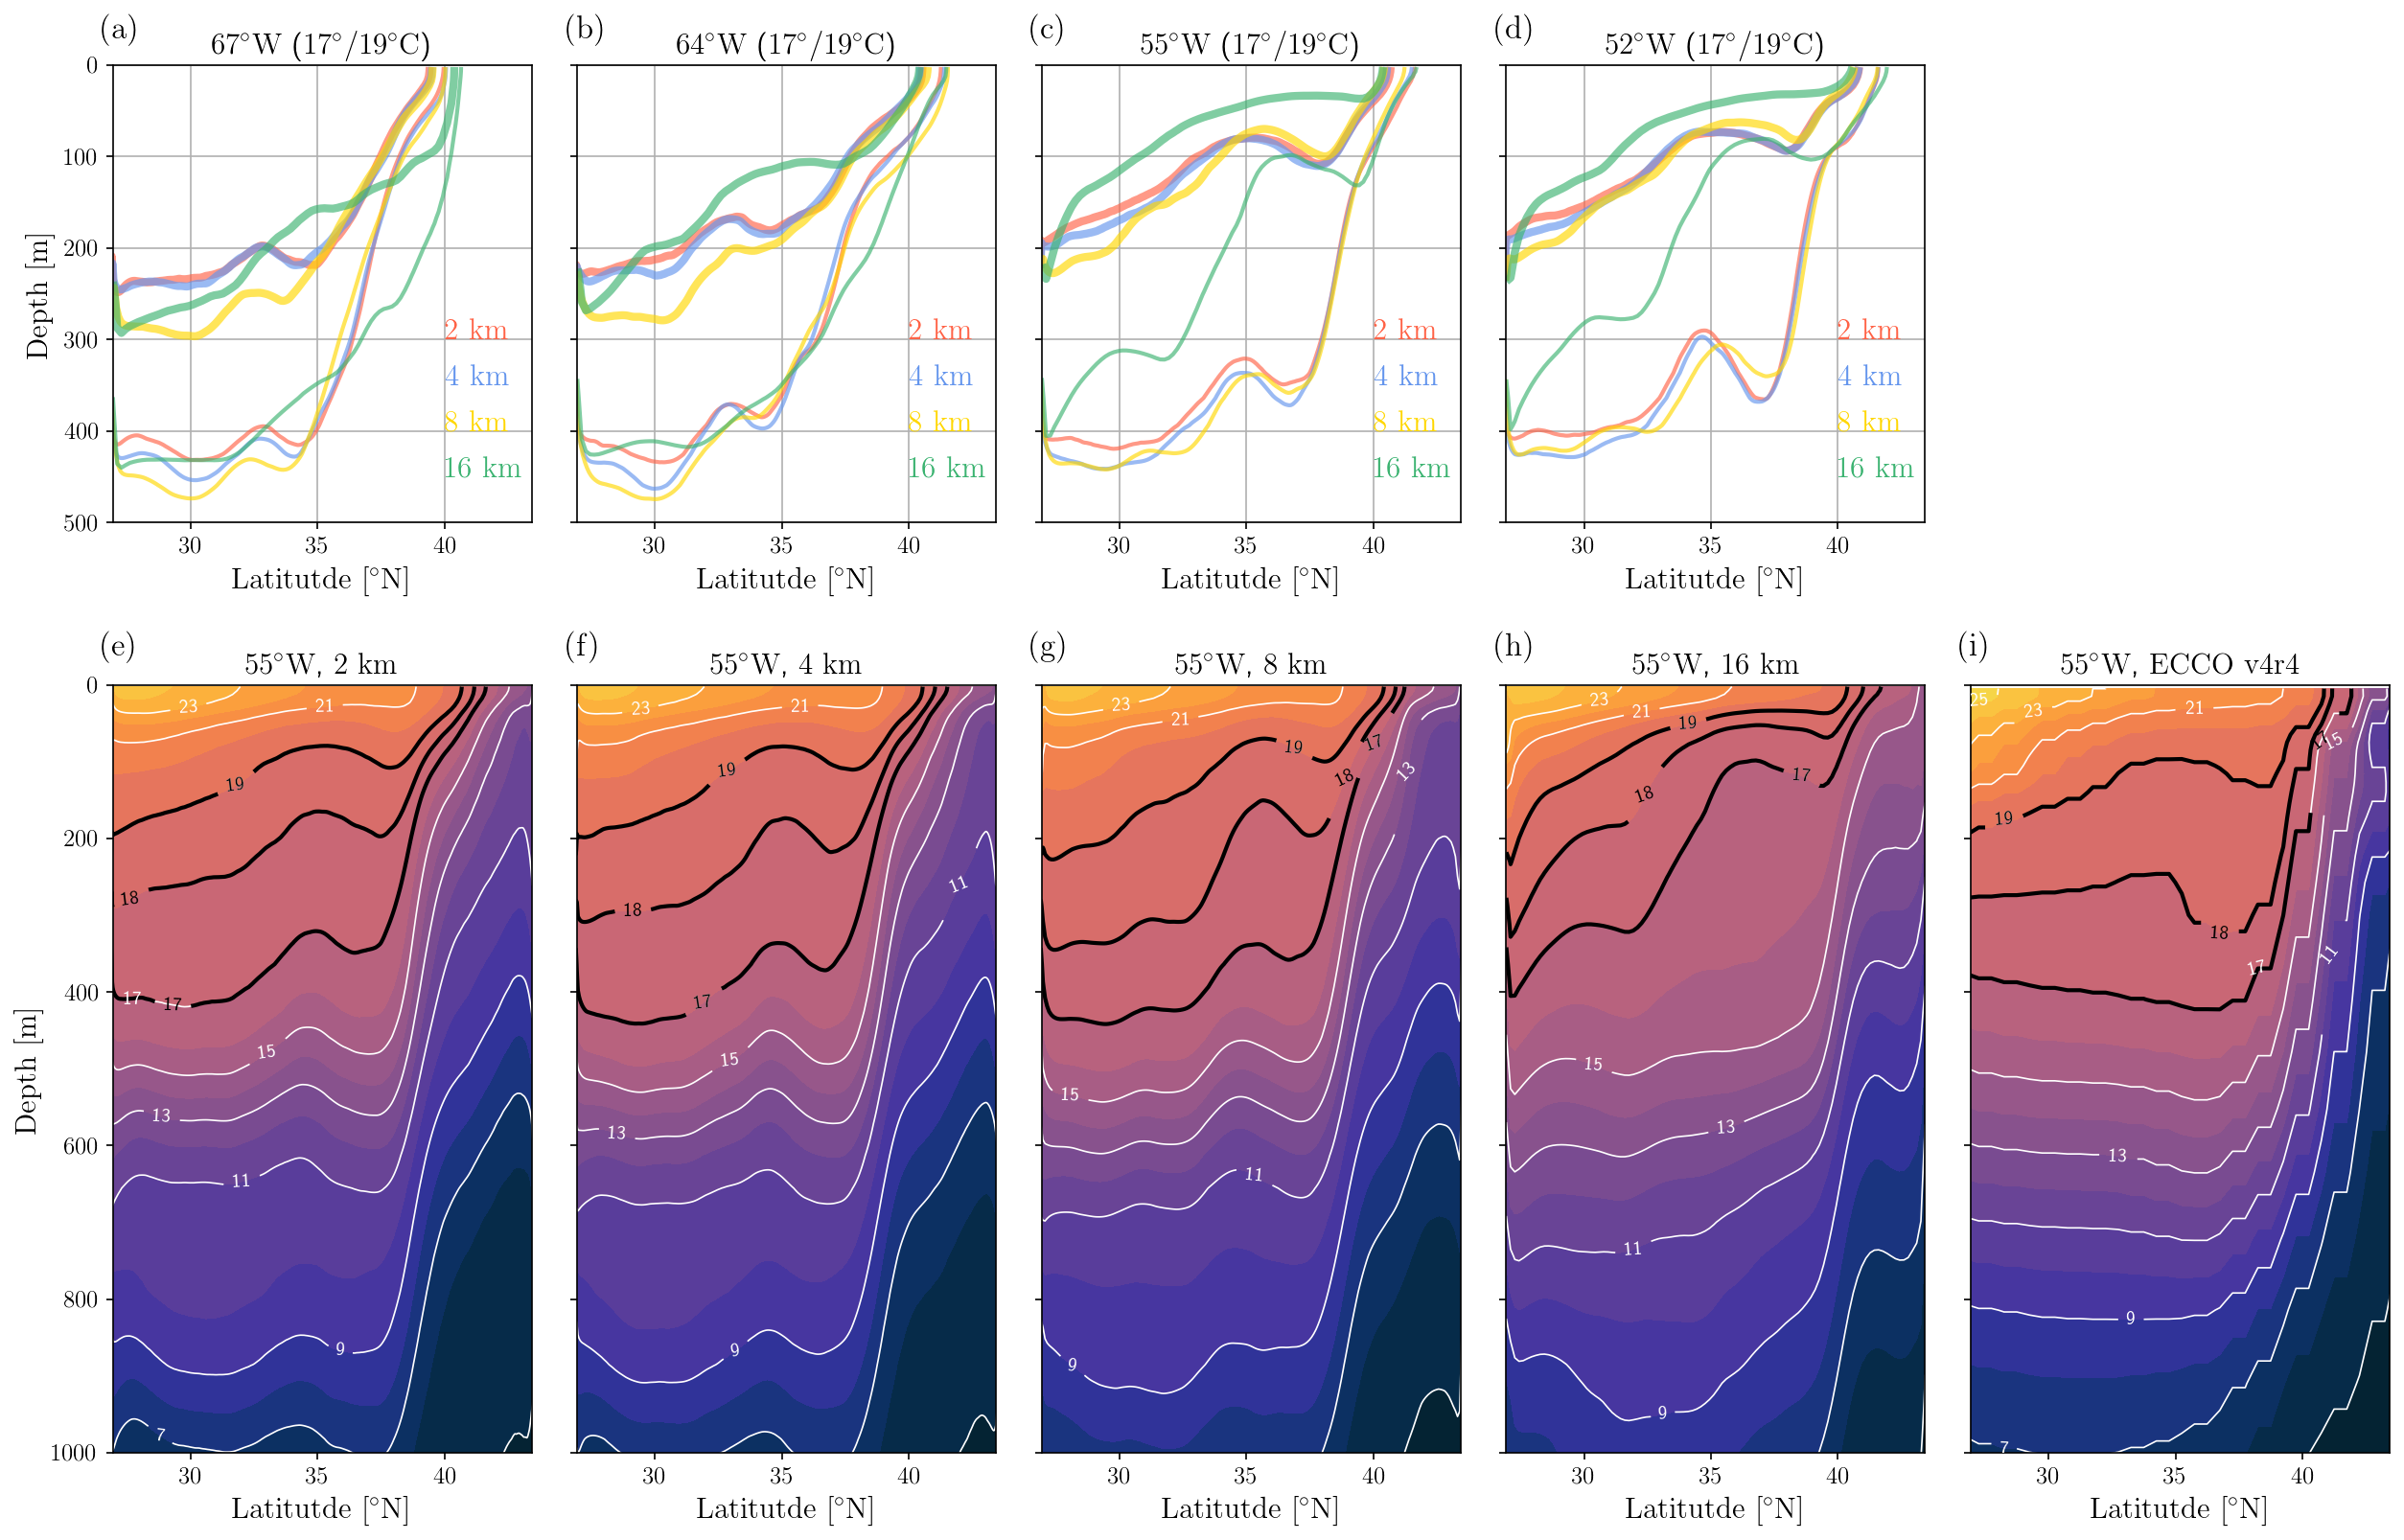

In [219]:
fig = plt.figure(figsize=(17,11), dpi=150, tight_layout=True)



xlim0 = np.max([T52[r].YC.min().values for r in ['2km','4km','8km','16km','eccov4r4']])
xlim1 = np.min([T52[r].YC.max().values for r in ['2km','4km','8km','16km','eccov4r4']])

plt.subplot2grid((5,5),(0,0), rowspan=2, colspan=1)
for i, r in enumerate(res):
    T67[r].plot.contour(colors=(colours[r]), levels=[17],linewidths=2, alpha=0.65)
    T67[r].plot.contour(colors=(colours[r]), levels=[19],linewidths=4, alpha=0.65)

plt.text(40,-300,labels['2km'],fontsize=15,color=colours['2km'])
plt.text(40,-350,labels['4km'],fontsize=15,color=colours['4km'])
plt.text(40,-400,labels['8km'],fontsize=15,color=colours['8km'])
plt.text(40,-450,labels['16km'],fontsize=15,color=colours['16km'])


plt.ylim([-500,0])
plt.xlim([xlim0,xlim1])
plt.yticks([0,-100,-200,-300,-400,-500],[r'$\mathrm{0}$',r'$\mathrm{100}$',r'$\mathrm{200}$',r'$\mathrm{300}$',r'$\mathrm{400}$',r'$\mathrm{500}$',], )
plt.xticks([30,35,40],[r'$\mathrm{30}$',r'$\mathrm{35}$',r'$\mathrm{40}$',])
plt.xlabel(r'$\mathrm{Latitutde~[^{\circ}N}]$', fontsize=15);
plt.ylabel(r'$\mathrm{Depth~[m]}$', fontsize=15)
plt.title(r'$\mathrm{67^{\circ}W}$ ($\mathrm{17^{\circ} / 19^{\circ} C}$) ', fontsize=15)
plt.grid()
plt.text(26.5,30, r'$\mathrm{(a)}$')

plt.subplot2grid((5,5),(0,1), rowspan=2, colspan=1)
for i, r in enumerate(res):
    T64[r].plot.contour(colors=(colours[r]), levels=[17],linewidths=2, alpha=0.65)
    T64[r].plot.contour(colors=(colours[r]), levels=[19],linewidths=4, alpha=0.65)

plt.text(40,-300,labels['2km'],fontsize=15,color=colours['2km'])
plt.text(40,-350,labels['4km'],fontsize=15,color=colours['4km'])
plt.text(40,-400,labels['8km'],fontsize=15,color=colours['8km'])
plt.text(40,-450,labels['16km'],fontsize=15,color=colours['16km'])

plt.ylim([-500,0])
plt.xlim([xlim0,xlim1])
plt.yticks([0,-100,-200,-300,-400,-500],[], )
# plt.gca().tick_params(axis='y',label2On=False)
plt.xticks([30,35,40],[r'$\mathrm{30}$',r'$\mathrm{35}$',r'$\mathrm{40}$',])
plt.xlabel(r'$\mathrm{Latitutde~[^{\circ}N}]$', fontsize=15);
plt.ylabel('')
plt.title(r'$\mathrm{64^{\circ}W}$ ($\mathrm{17^{\circ} / 19^{\circ} C}$) ', fontsize=15)
plt.grid()
plt.text(26.5,30, r'$\mathrm{(b)}$')

plt.subplot2grid((5,5),(0,2), rowspan=2, colspan=1)
for i, r in enumerate(res):
    T55[r].plot.contour(colors=(colours[r]), levels=[17],linewidths=2, alpha=0.65)
    T55[r].plot.contour(colors=(colours[r]), levels=[19],linewidths=4, alpha=0.65)

plt.text(40,-300,labels['2km'],fontsize=15,color=colours['2km'])
plt.text(40,-350,labels['4km'],fontsize=15,color=colours['4km'])
plt.text(40,-400,labels['8km'],fontsize=15,color=colours['8km'])
plt.text(40,-450,labels['16km'],fontsize=15,color=colours['16km'])

plt.ylim([-500,0])
plt.xlim([xlim0,xlim1])
plt.yticks([0,-100,-200,-300,-400,-500],[], )
# plt.gca().tick_params(axis='y',label2On=False)
plt.xticks([30,35,40],[r'$\mathrm{30}$',r'$\mathrm{35}$',r'$\mathrm{40}$',])
plt.xlabel(r'$\mathrm{Latitutde~[^{\circ}N}]$', fontsize=15);
plt.ylabel('')
plt.title(r'$\mathrm{55^{\circ}W}$ ($\mathrm{17^{\circ} / 19^{\circ} C}$) ', fontsize=15)
plt.grid()
plt.text(26.5,30, r'$\mathrm{(c)}$')

plt.subplot2grid((5,5),(0,3), rowspan=2, colspan=1)
for i, r in enumerate(res):
    T52[r].plot.contour(colors=(colours[r]), levels=[17],linewidths=2, alpha=0.65)
    T52[r].plot.contour(colors=(colours[r]), levels=[19],linewidths=4, alpha=0.65)

plt.text(40,-300,labels['2km'],fontsize=15,color=colours['2km'])
plt.text(40,-350,labels['4km'],fontsize=15,color=colours['4km'])
plt.text(40,-400,labels['8km'],fontsize=15,color=colours['8km'])
plt.text(40,-450,labels['16km'],fontsize=15,color=colours['16km'])
plt.ylim([-500,0])
plt.xlim([xlim0,xlim1])
plt.yticks([0,-100,-200,-300,-400,-500],[], )
# plt.gca().tick_params(axis='y',label2On=False)
plt.xticks([30,35,40],[r'$\mathrm{30}$',r'$\mathrm{35}$',r'$\mathrm{40}$',])
plt.xlabel(r'$\mathrm{Latitutde~[^{\circ}N}]$', fontsize=15);
plt.ylabel('')
plt.title(r'$\mathrm{52^{\circ}W}$ ($\mathrm{17^{\circ} / 19^{\circ} C}$) ', fontsize=15)
plt.grid()
#plt.legend()
plt.text(26.5,30, r'$\mathrm{(d)}$')

textlabels = [r'$\mathrm{(e)}$',r'$\mathrm{(f)}$',r'$\mathrm{(g)}$',r'$\mathrm{(h)}$',r'$\mathrm{(i)}$', ]

for i, r in enumerate(['2km','4km','8km','16km','eccov4r4']):
    plt.subplot2grid((5,5),(2,i), rowspan=3, colspan=1)
    T55[r].plot.contourf(cmap=cmocean.cm.thermal, levels=np.arange(5,28,1), extend='both', add_labels=False, add_colorbar=False)
    cs4=T55[r].plot.contour(colors=('#ffffff'), levels=np.arange(5,28,1)[::2],linewidths=(0.8,))
    plt.clabel(cs4, fmt = '%.0f', colors = '#ffffff', fontsize=9);
    cs40=T55[r].plot.contour(colors=('#000000'), levels=[17,18,19],linewidths=(2,))
    plt.clabel(cs40, fmt = '%.0f', colors = '#000000', fontsize=9);    
    
    #T55[r].plot.contourf(colors=(colours[i]), levels=[15,20],linewidths=(3,))
    plt.ylim([-1000,0])
    plt.xlim([xlim0,xlim1])
    plt.xlabel(r'$\mathrm{Latitutde~[^{\circ}N}]$', fontsize=15);
    plt.text(26.5,40, textlabels[i])

    if(r=='2km'):    
        plt.ylabel(r'$\mathrm{Depth~[m]}$', fontsize=15)
        plt.yticks([0,-200,-400,-600,-800,-1000],[r'$\mathrm{0}$',r'$\mathrm{200}$',r'$\mathrm{400}$',r'$\mathrm{600}$',r'$\mathrm{800}$',r'$\mathrm{1000}$'], )

    else:
        plt.ylabel('')
        plt.yticks([0,-200,-400,-600,-800,-1000],[], )
#         plt.gca().tick_params(axis='y',label2On=False)
    plt.xticks([30,35,40],[r'$\mathrm{30}$',r'$\mathrm{35}$',r'$\mathrm{40}$',])
    
    plt.title(r'$\mathrm{55^{\circ} W}$, '+ labels[r], fontsize=15)

fig.savefig(figdir + 'mwt_sections_model+ecco_wlabels')
fig.savefig(figdir + 'mwt_sections_model+ecco_wlabels.pdf')

In [153]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

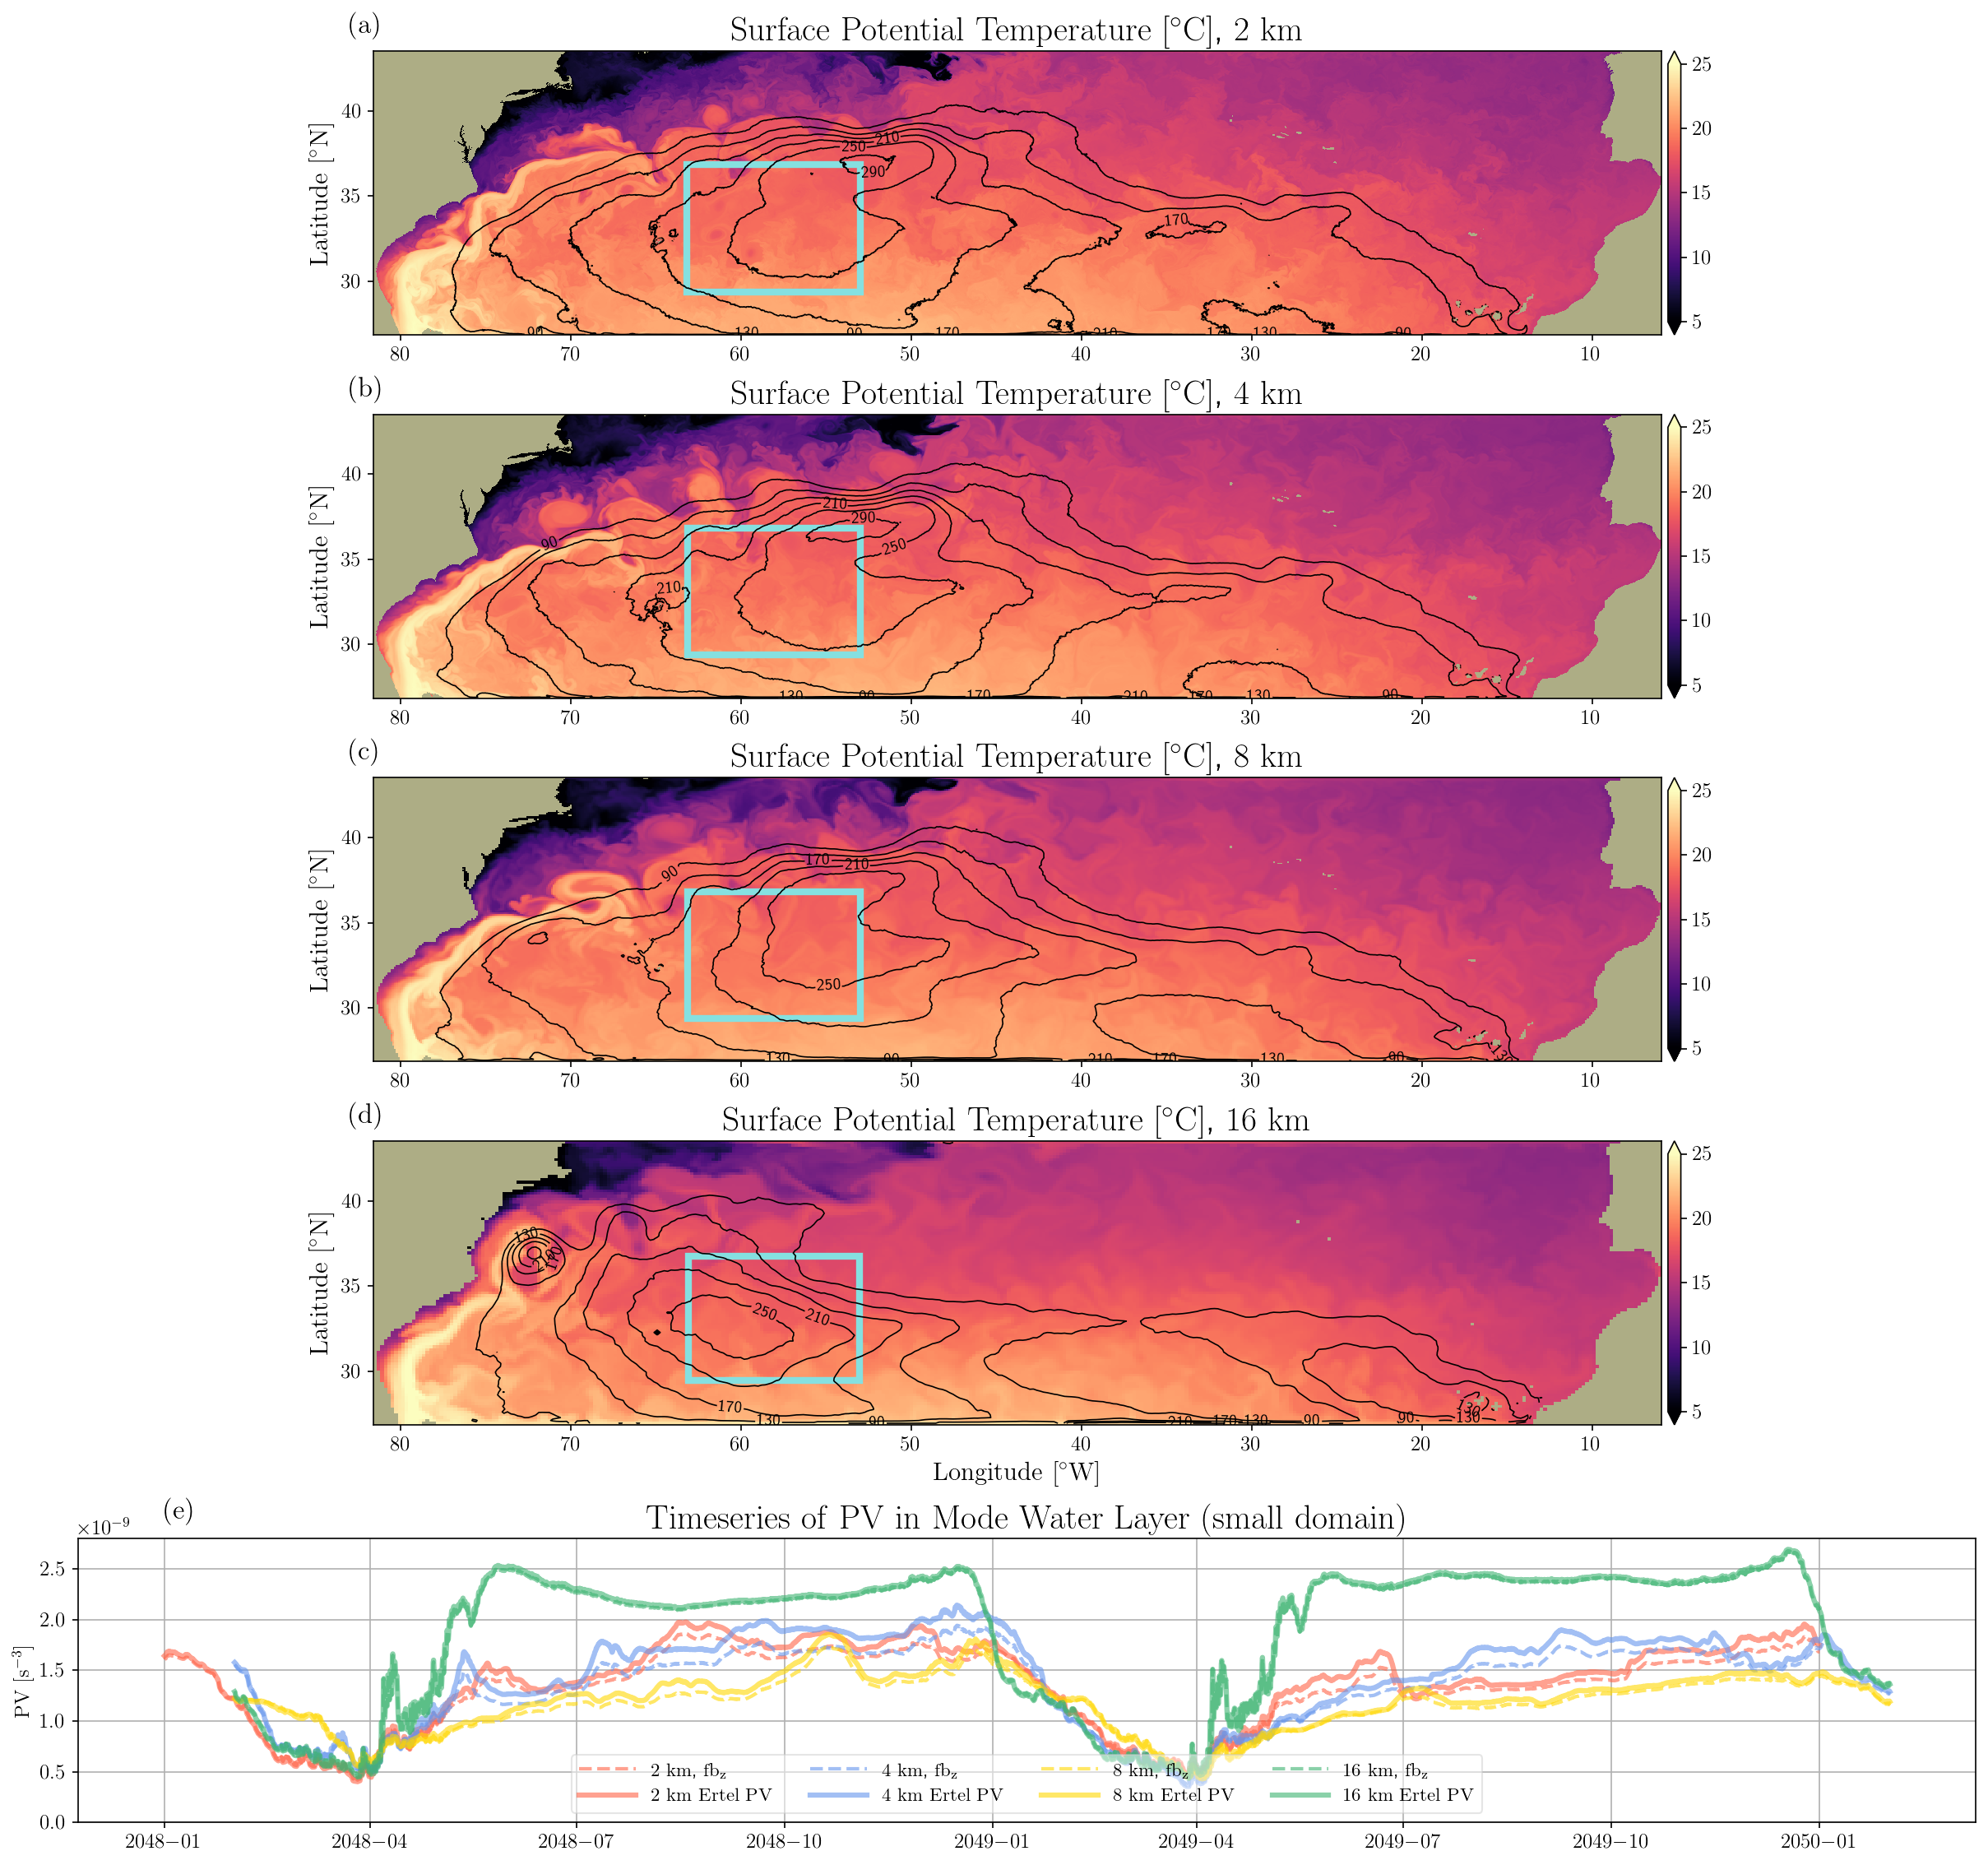

In [163]:
fig, axes = plt.subplots(figsize=(16,15), dpi=150, nrows=5, ncols=1, constrained_layout=True)
axtexts = [r'$\mathrm{(a)}$',r'$\mathrm{(b)}$',r'$\mathrm{(c)}$',r'$\mathrm{(d)}$',]

for i, r in enumerate(res):
    im0 = axes[i].pcolormesh(x[r],y[r],Ts[r], vmin=5, vmax=25,cmap='magma', shading='auto', rasterized=True);
    divider = make_axes_locatable(axes[i])
    cax = divider.append_axes('right', size='1%', pad=0.05)
    cbar = fig.colorbar(im0, cax=cax, orientation='vertical', shrink=0.7, extend='both')
    csx = axes[i].contour(x[r],y[r], mwtvpv_tm[r].mwt.where(mwtvpv_tm[r].mwt>50), levels=np.arange(50,320,40), colors = 'k', linewidths=(0.8,))
#     csx=mwtvpv_tm[r].mwt.where(mwtvpv_tm[r].mwt>50).plot.contour(levels=np.arange(50,320,40), colors = 'k', linewidths=(0.8,), add_labels=False)
    axes[i].clabel(csx, fmt = '%3.0f', colors = '#000000', fontsize=9);
    axes[i].pcolormesh(x[r],y[r],landmask[r],cmap=mpl.colors.ListedColormap(['#adad85']), shading='auto', rasterized=True)
    axes[i].set_title(r'$\mathrm{Surface~Potential~Temperature~[^{\circ} C]}$, ' + labels[r])
    axes[i].set_yticks([30,35,40])
    axes[i].set_yticklabels([r'$30$',r'$35$',r'$40$'])
    axes[i].set_xticks([-80,-70,-60,-50,-40,-30,-20,-10])
    axes[i].set_xticklabels([r'$80$',r'$70$',r'$60$',r'$50$',r'$40$',r'$30$',r'$20$',r'$10$'])

    axes[i].set_ylabel(r'$\mathrm{Latitude~[^{\circ}N]}$', fontsize=15)
    if (i==3):
        axes[i].set_xlabel(r'$\mathrm{Longitude~[^{\circ}W]}$', fontsize=15)
    else:
        axes[i].set_xlabel('')
    rect = patches.Rectangle((grids2[r].XC.min().values,grids2[r].YC.min().values),
                                               grids2[r].XC.max().values - grids2[r].XC.min().values,
                                               grids2[r].YC.max().values - grids2[r].YC.min().values, linewidth=4,edgecolor='#85e0e0',facecolor='none')
    axes[i].add_patch(rect)
    axes[i].text(-83,44.6, axtexts[i])
    axes[i].set_aspect(aspect=1, anchor='SW')



for i, r in enumerate(res):
    axes[4].plot(pvsmall_ts[r].time, pvsmall_ts[r].fbz_mw, color=colours[r], linewidth=2, linestyle='dashed', alpha=0.6, label=labels[r]+ r', $\mathrm{f b_z}$')
    axes[4].plot(pvsmall_ts[r].time, pvsmall_ts[r].PV_mw, color=colours[r], linewidth=3, alpha=0.6, label=labels[r] + r' $\mathrm{Ertel~PV}$')
axes[4].set_title(r'$\mathrm{Timeseries~of~PV~in~Mode~Water~Layer~(small~domain)}$')
axes[4].set_ylabel(r'$\mathrm{PV}$ $[\mathrm{s^{-3}}]$')
axes[4].grid()
axes[4].legend(loc=8, ncol=4, framealpha=0.5, fontsize=11)
axes[4].text('2048-01',3e-9, r'$\mathrm{(e)}$')
axes[4].set_ylim([0,2.8e-9]);
fig.savefig(figdir + 'surface_T_mwt_PVsmall_timeseries')
fig.savefig(figdir + 'surface_T_mwt_PVsmall_timeseries.pdf', dpi=150)
